<a href="https://colab.research.google.com/github/pedrocalheiross/projeto-ciencia-de-dados/blob/main/desmatamento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Ciência de Dados

Pedro Barros de Souza Lima - pbsl@cin.ufpe.br

Pedro Calheiros de Araújo - pca@cin.ufpe.br

Dataset encontrado em: https://dados.gov.br/dados/conjuntos-dados/incendios-em-unidades-de-conservacao-federais

Arquivos importantes: https://www.gov.br/icmbio/pt-br/acesso-a-informacao/dados-abertos/arquivos/sistema-de-analise-e-monitoramento-da-efetividade-de-gestao-samge/dados-do-samge-1-identificacao-e-resultados.xlsx

###**Objetivos:**

1. Coletar dados	✅

2.	Realizar pré-processamento dos dados:
  * Definição	de	tipos ✅
  * Tratamento	de	dados	ausentes ✅
  * Normalização	e	discretização ✅
  * Limpeza	de	dados	(univariado,	bivariado	e	multivariado) ~✅

3.	Apresentar estatísticas descritivas	dos	dados com	visualizações ✅

4.	Realizar teste	de	hipóteses para comparação de	valores	de	categorias	(ex.	preço	m2 em diferentes bairros)	e	visualizar diferenças ✅
* Bônus:
  * Integrar	dados	ou extrair	dados	da	Web
  * Utilizar técnicas não cobertas nas aulas

### Imports

In [ ]:
import requests
#from http.client import responses
#from os.path import dirname
#from os import environ
#import inspect
#import json
#import gzip
import pandas as pd
import numpy as np
from math import log10
from scipy import stats
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler #, MinMaxScaler
#from time import sleep

### Funções

In [ ]:
def analiseTipos(df:pd.DataFrame, feature:str = None):
  '''Para printar uma contagem dos tipos, incluindo valores <NAN>
  Caso o parâmentro "feature" não seja declarado, será feito o .dtypes do dataframe "df"'''
  if(feature):
    print(f'''Num <NAN>: {len(df[df[feature].isna()])}

{df[feature].apply(lambda x: type(x)).value_counts()}''')
  else:
    print(f'Num <NAN>: {len(df[df.isna()])}\n')
    print(df.dtypes)

## Pré-análise dos dados

Coleta dos dados principais:

In [ ]:
df = pd.read_excel('/content/tabela_de_desmatamento_ucs.xlsx', sheet_name=0, header=1)
df = df.drop(df.index[-1])
df = df.assign(bioma = "Amazônia")
for b in ['Mata Atlântica', 'Pampa', 'Cerrado', 'Caatinga']: # tirei o pantanal porque dados estavam incompletos
  temp = pd.read_excel('/content/tabela_de_desmatamento_ucs.xlsx', sheet_name=b, header=1)
  temp = temp.drop(temp.index[-1])
  temp = temp.assign(bioma = b)
  df = pd.concat([df, temp], ignore_index=True)

In [ ]:
df.columns

Index([                  'cnuc', 'unidade de conservação',
                   'área_ha_uc',               'Até 2007',
                           2008,                     2009,
                           2010,                     2011,
                           2012,                     2013,
                           2014,                     2015,
                           2016,                     2017,
                           2018,                     2019,
                           2020,                     2021,
                           2022,                     2023,
                        'TOTAL',                  'bioma',
                     'Até 2000',            '2001 a 2004',
                           2006,                     2002,
                           2004],
      dtype='object')

---
### Verificação da coluna 'TOTAL' e remoção de registros pré-2008


In [ ]:
cols = ['Até 2007', 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
        2018, 2019, 2020, 2021, 2022, 2023, 'Até 2000', '2001 a 2004', 2006, 2002, 2004]

df.assign(total_check=lambda x: x.loc[:,cols].sum(axis=1))[['unidade de conservação', 'bioma', 'TOTAL', 'total_check']]

unidade de conservação     bioma      TOTAL  \
0                                APA do Igarapé Gelado  Amazônia    9146.70   
1                                       APA do Tapajós  Amazônia  137537.01   
2                           APA dos Campos de Manicoré  Amazônia     215.43   
3    ARIE Projeto Dinâmica Biológica de Fragmento F...  Amazônia      74.26   
4                         ARIE Seringal Nova Esperança  Amazônia    1777.85   
..                                                 ...       ...        ...   
316                                     REBIO Guaribas  Caatinga      20.16   
317                                   RESEX do Batoque  Caatinga     105.36   
318                       RESEX Prainha do Canto Verde  Caatinga      72.90   
319                             REVIS da Ararinha Azul  Caatinga     111.72   
320                                  REVIS de Boa Nova  Caatinga    1670.72   

     total_check  
0        9146.70  
1      137537.01  
2         215.43  
3          74.26  
4        1777.85  
..           ...  
316        20.16  
317       105.36  
318        72.90  
319       111.72  
320      1670.72  

[321 rows x 4 columns]

Se você for comparar os valores da soma e do TOTAL, pelo pandas vai dizer que alguns não são iguais, mas se compararmos visualmente, claramente não há diferença. Provavelmente é uma diferença na leitura dos floats ou na computação da soma. Não há diferenças relevantes.

De qualquer forma ela será removida porque, ao final do tratamento dos dados, ela não será útil, já que parte dos valores que se somavam para dar o valor em TOTAL foi retirado, ou foi adicionado algum valor no lugar de dados ausentes.

In [ ]:
df = df.drop(columns=['Até 2007', '2001 a 2004', 'Até 2000', 2002, 2006, 2004, 'TOTAL'])

In [ ]:
df

cnuc                             unidade de conservação  \
0    0000.00.0022                              APA do Igarapé Gelado   
1    0000.00.0268                                     APA do Tapajós   
2    0000.00.3407                         APA dos Campos de Manicoré   
3    0000.00.0043  ARIE Projeto Dinâmica Biológica de Fragmento F...   
4    0000.00.0044                       ARIE Seringal Nova Esperança   
..            ...                                                ...   
316  0000.00.0196                                     REBIO Guaribas   
317  0000.00.0231                                   RESEX do Batoque   
318  0000.00.1809                       RESEX Prainha do Canto Verde   
319  0000.00.3694                             REVIS da Ararinha Azul   
320  0000.00.1907                                  REVIS de Boa Nova   

       área_ha_uc     2008     2009    2010     2011     2012     2013  \
0    2.071467e+04   119.53     0.00    5.15     0.00     0.00    10.63   
1    2.040336e+06  1648.94  1523.54  829.74  1352.57  2238.81  3246.37   
2    1.521325e+05     0.00    24.53    4.32    16.52     0.00     0.00   
3    3.336296e+03     0.00     0.00    0.00     0.00     0.00     0.00   
4    2.573984e+03    13.01    25.32   28.75    34.40   222.00    26.89   
..            ...      ...      ...     ...      ...      ...      ...   
316  4.051657e+03     0.39      NaN    0.00     0.00      NaN     0.00   
317  6.014409e+02     0.00      NaN   14.70     0.00      NaN     5.94   
318  2.980527e+04     0.00      NaN   30.13     0.00      NaN     0.00   
319  2.923449e+04     7.68      NaN   17.78     0.00      NaN    19.26   
320  1.483345e+04    32.18      NaN   14.57     0.00      NaN     1.31   

        2014     2015     2016     2017     2018     2019     2020      2021  \
0       0.00     0.00     0.09     0.00     0.00     9.81    23.75      7.68   
1    2872.94  3437.89  3143.69  3229.61  3895.20  6552.78  6963.76  10646.08   
2       0.00     0.00    11.59    26.83    11.19    40.52     0.00     20.45   
3       0.00     0.00     0.00     0.00     0.00     0.00     0.00      0.00   
4     132.50    89.38    78.45    61.09    55.34    70.91    57.78    119.10   
..       ...      ...      ...      ...      ...      ...      ...       ...   
316     0.00      NaN     0.11     0.00     0.00     0.00     0.00      0.00   
317     0.00      NaN     0.00     0.00     0.00     0.00     0.00      0.00   
318     0.00      NaN     2.89     0.00     0.00    12.68     0.00      0.00   
319     9.08      NaN     3.65     0.00     0.00     6.27     4.79      3.23   
320     0.00      NaN    27.94     0.00     0.00     1.53     0.00      0.00   

         2022     2023     bioma  
0       14.29     0.00  Amazônia  
1    11140.01  4879.10  Amazônia  
2       29.66     1.71  Amazônia  
3        0.00     0.00  Amazônia  
4       61.31    90.59  Amazônia  
..        ...      ...       ...  
316      0.00      NaN  Caatinga  
317      0.00      NaN  Caatinga  
318      0.00      NaN  Caatinga  
319      0.00      NaN  Caatinga  
320     12.59      NaN  Caatinga  

[321 rows x 20 columns]

---
### Verificação de Unidades de Conservação (UC) duplicadas

In [ ]:
(df['unidade de conservação'].value_counts() > 1).sum()

17

In [ ]:
cols = ['unidade de conservação', 'bioma']
df.loc[:,cols].groupby(by='unidade de conservação').aggregate('count').sort_values(by='bioma', ascending=False).head(18)

bioma
unidade de conservação                      
PARNA Cavernas do Peruaçu                  2
APA das Ilhas e Várzeas do Rio Paraná      2
PARNA Serra de Itabaiana                   2
RESEX do Ciriaco                           2
APA da Barra do Rio Mamanguape             2
REBIO Guaribas                             2
PARNA de Boa Nova                          2
FLONA de Capão Bonito                      2
PARNA da Serra das Confusões               2
RESEX da Baía do Tubarão                   2
RESEX da Mata Grande                       2
REVIS de Boa Nova                          2
APA Serra da Ibiapaba                      2
APA Morro da Pedreira                      2
APA Delta do Parnaíba                      2
PARNA da Serra do Cipó                     2
APA Cavernas do Peruaçu                    2
REBIO Augusto Ruschi                       1

UCs repetidas são compostas por 2 biomas. É importante deixá-las como instâncias separadas porque a área desmatada é diferente entre biomas da mesma UC.

In [ ]:
df[df['unidade de conservação'] == 'PARNA Cavernas do Peruaçu']

cnuc     unidade de conservação   área_ha_uc    2008  2009  \
259  0000.00.0135  PARNA Cavernas do Peruaçu  56448.64549    8.68   NaN   
303  0000.00.0135  PARNA Cavernas do Peruaçu  56448.64549  142.74   NaN   

      2010  2011   2012    2013   2014  2015   2016   2017   2018   2019  \
259  26.68   NaN  75.26    7.09   1.01   0.0   0.00  10.12  12.59   0.00   
303  86.69  4.96    NaN  241.22  82.60   NaN  78.57  41.40  61.49  13.29   

     2020   2021  2022  2023     bioma  
259   0.0   0.00   0.0   NaN   Cerrado  
303   5.1  15.49   0.0   NaN  Caatinga

---
### Coleta & Integração das Unidades Federativas ao dataset principal
(+ rápida análise + remoção de duplicatas)


In [ ]:
dfid = pd.read_excel('/content/dados-do-samge-1-identificacao-e-resultados.xlsx').loc[:,['Nome da UC', 'UF']]

In [ ]:
dfid.head()

Nome da UC      UF
0                           APA ANHATOMIRIM      SC
1                   APA CAVERNAS DO PERUAÇU      MG
2            APA DA BACIA DO RIO DESCOBERTO  DF, GO
3        APA DA BACIA DO RIO SÃO BARTOLOMEU      DF
4  APA DA BACIA DO RIO SÃO JOÃO - MICO LEÃO      RJ

In [ ]:
dfid['Nome da UC'].value_counts()

Nome da UC
FLONA DE TRÊS BARRAS            6
PARNA DE BRASÍLIA               6
PARNA DE ILHA GRANDE            6
PARNA DE SAINT-HILAIRE/LANGE    6
PARNA DE SÃO JOAQUIM            6
                               ..
APA BAÍA NEGRA                  1
FE DO RIO LIBERDADE             1
FE DO RIO GREGÓRIO              1
FE DO MOGNO                     1
PNM FAZENDA DO CARMO            1
Name: count, Length: 779, dtype: int64

In [ ]:
dfid[dfid['Nome da UC'] == 'FLONA DE TRÊS BARRAS']

Nome da UC  UF
124   FLONA DE TRÊS BARRAS  SC
769   FLONA DE TRÊS BARRAS  SC
1415  FLONA DE TRÊS BARRAS  SC
1951  FLONA DE TRÊS BARRAS  SC
2459  FLONA DE TRÊS BARRAS  SC
2774  FLONA DE TRÊS BARRAS  SC

In [ ]:
print(len(dfid))
len(dfid.drop_duplicates())

2907


779

Não foi apresentado aqui no código, mas na planilha original, a diferença entre essas duplicatas são apenas o ano do registro, que é importante para dados referentes ao gerenciamento das UCs.

Como nós só precisamos do(s) estado(s) onde estão localizadas, não tem porquê manter essas duplicatas:  

In [ ]:
dfid = dfid.drop_duplicates()
df['unidade de conservação'] = df['unidade de conservação'].apply(lambda x: x.upper())
df = pd.merge(df, dfid, how='inner', right_on='Nome da UC', left_on='unidade de conservação').drop(columns=['Nome da UC'])
df[df['unidade de conservação'] == 'APA DA BACIA DO RIO DESCOBERTO']

cnuc          unidade de conservação    área_ha_uc    2008  2009  \
168  0000.00.0003  APA DA BACIA DO RIO DESCOBERTO  36159.770194  121.38   NaN   

      2010  2011   2012   2013    2014  ...   2016   2017   2018  2019   2020  \
168  81.63   NaN  48.05  25.85  241.22  ...  27.55  47.46  39.52  6.13  16.94   

      2021   2022  2023    bioma      UF  
168  29.47  10.97   NaN  Cerrado  DF, GO  

[1 rows x 21 columns]

---
### Definição de tipos

In [ ]:
df.dtypes

cnuc                       object
unidade de conservação     object
área_ha_uc                float64
2008                      float64
2009                      float64
2010                      float64
2011                      float64
2012                      float64
2013                      float64
2014                      float64
2015                      float64
2016                      float64
2017                      float64
2018                      float64
2019                      float64
2020                      float64
2021                      float64
2022                      float64
2023                      float64
bioma                      object
UF                         object
dtype: object

In [ ]:
df['cnuc'].nunique() == df['unidade de conservação'].nunique()

True

In [ ]:
print(df['UF'].unique())
df['UF'].nunique()

['PA' 'AM' 'AC' 'AM, RO' 'RR' 'AP, PA' 'RO' 'AM, PA' 'AP' 'AM, MT'
 'AM, MT, RO' 'AM, RR' 'MA' 'SC' 'ES' 'RJ' 'PR' 'MG' 'SP' 'RS' 'AL' 'RN'
 'SE' 'RJ, SP' 'BA' 'RS, SC' 'MS, PR' 'AL, PE' 'PE' 'PB' 'DF, GO' 'DF'
 'GO' 'CE, PI' 'TO' 'MT' 'PI' 'BA, TO' 'MS' 'CE']


40

In [ ]:
print(df.loc[:,'UF'][df['UF'].str.len() == 2].unique())
df.loc[:,'UF'][df['UF'].str.len() == 2].nunique()

['PA' 'AM' 'AC' 'RR' 'RO' 'AP' 'MA' 'SC' 'ES' 'RJ' 'PR' 'MG' 'SP' 'RS'
 'AL' 'RN' 'SE' 'BA' 'PE' 'PB' 'DF' 'GO' 'TO' 'MT' 'PI' 'MS' 'CE']


27

Todos os estados estão listados

In [ ]:
df.loc[:,'UF'][df['UF'].str.len() > 2].value_counts()

UF
DF, GO        4
AM, RO        2
AP, PA        2
RS, SC        2
CE, PI        2
AM, PA        1
AM, MT        1
AM, MT, RO    1
AM, RR        1
RJ, SP        1
MS, PR        1
AL, PE        1
BA, TO        1
Name: count, dtype: int64

In [ ]:
co = ['AL', 'PE', 'PB', 'RN', 'SE', 'CE', 'PI', 'MA', 'BA', # NE  (1) 0-8
      'TO', 'PA', 'AC', 'RR', 'RO', 'AP', 'AM',             # N   (1) 9-15
      'MT', 'MS', 'DF', 'GO',                               # CO  (1) 16-19
      'PR', 'RS', 'SC',                                     # S   (1) 20-22
      'ES', 'RJ', 'MG', 'SP',                               # SE  (1) 23-26
      'AL, PE', 'CE, PI',                     # NE      (2) 27-28
      'BA, TO',                               # NE, N   (2) 29
      'AM, RO', 'AM, PA', 'AM, RR', 'AP, PA', # N       (2) 30-33
      'AM, MT', 'AM, MT, RO',                 # N, CO   (2)(3) 34-35
      'DF, GO',                               # CO      (2) 36
      'MS, PR',                               # CO, S   (2) 37
      'RS, SC',                               # S       (2) 38
      'RJ, SP'                                # SE      (2) 39
      ]

df['UF'] = df['UF'].astype(pd.api.types.CategoricalDtype(categories=co))

Não acho que vale a pena aumentar o número de UCs para que cada instância tenha apenas uma UF relacionada. Elas já foram dividas de acordo com seus biomas, além disso, não temos como relacionar um bioma a um estado exclusivamente porque biomas não respeitam fronteiras artificiais.

In [ ]:
df['bioma'].unique(), df['bioma'].nunique()

(array(['Amazônia', 'Cerrado', 'Mata Atlântica', 'Caatinga', 'Pampa'],
       dtype=object),
 5)

In [ ]:
df['bioma'] = df['bioma'].astype('category')
df['bioma'].cat.categories

Index(['Amazônia', 'Caatinga', 'Cerrado', 'Mata Atlântica', 'Pampa'], dtype='object')

Criação da coluna "região":

In [ ]:
df[df['UF'].isin(['BA, TO', 'AM, MT', 'AM, MT, RO', 'MS, PR'])]

cnuc         unidade de conservação    área_ha_uc    2008   2009  \
43   0000.00.0281               PARNA DO JURUENA  1.957028e+06  363.50   0.00   
47   0000.00.0284    PARNA DOS CAMPOS AMAZÔNICOS  9.613137e+05  385.13  71.51   
132  0000.00.0161           PARNA DE ILHA GRANDE  7.613765e+04   31.33    NaN   
178  0000.00.0076  ESEC SERRA GERAL DO TOCANTINS  7.070848e+05  289.34    NaN   

      2010    2011   2012    2013    2014  ...  2016   2017   2018    2019  \
43   62.79   79.32   7.30   35.90    0.00  ...  7.62  10.86  10.09   48.89   
47   17.94  139.62  48.76  192.89    0.00  ...  1.11  28.04  37.75  197.04   
132   0.00    9.25    NaN   18.49    0.00  ...  8.49  10.26   4.85   12.09   
178   4.64     NaN  10.33   30.61  115.32  ...  4.51   0.00   0.00    1.19   

       2020    2021    2022    2023           bioma          UF  
43    38.14   70.40   41.94   99.16        Amazônia      AM, MT  
47   514.00  735.05  363.06  182.31        Amazônia  AM, MT, RO  
132    8.09    0.00   14.80     NaN  Mata Atlântica      MS, PR  
178   16.96    6.94    2.38     NaN         Cerrado      BA, TO  

[4 rows x 21 columns]

Apenas 4 UCs estão presentes em mais de uma região.

In [ ]:
uf2reg = ['NE', 'N', 'CO', 'S', 'SE', 'NE', 'NE, N', 'N', 'N, CO', 'CO', 'CO, S', 'S', 'SE']

df['região'] = pd.cut(df.UF.cat.codes, [0, 9, 16, 20, 23, 27, 29, 30, 34, 36, 37, 38, 39, 40], ordered=False, labels=uf2reg, right=False)

# Define and apply arbitrary category order
# Essa ordem foi decidida porque se quiser fazer uma análise de bioma presentes
# nas regiões, por exemplo, Norte e/ou Centro-Oeste, é só especificar o intervalo
# dos índices de ambas as regiões, que também irá incluir UCs presentes em ambas
# ao mesmo tempo, df['região'].cat.categories[1:4] => ['N', 'N, CO', 'CO'],
# ou até df['região'].cat.categories[3:6] => ['N', 'N, CO', 'CO']
co = ['NE', 'NE, N', 'N', 'N, CO', 'CO', 'CO, S', 'S', 'SE']

df['região'] = df['região'].astype(pd.api.types.CategoricalDtype(categories=co))

df['região'].value_counts()

região
N        82
NE       57
SE       38
S        27
CO       12
N, CO     2
CO, S     1
NE, N     1
Name: count, dtype: int64

---
###Tratamento de dados ausentes

In [ ]:
cols = ['unidade de conservação', 'área_ha_uc', 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 'bioma']
df[cols].head()

unidade de conservação    área_ha_uc     2008     2009    2010  \
0         APA DO IGARAPÉ GELADO  2.071467e+04   119.53     0.00    5.15   
1                APA DO TAPAJÓS  2.040336e+06  1648.94  1523.54  829.74   
2    APA DOS CAMPOS DE MANICORÉ  1.521325e+05     0.00    24.53    4.32   
3  ARIE SERINGAL NOVA ESPERANÇA  2.573984e+03    13.01    25.32   28.75   
4               ESEC ALTO MAUÉS  6.665559e+05     0.00    16.64   31.22   

      2011     2012     2013     2014     2015     2016     2017     2018  \
0     0.00     0.00    10.63     0.00     0.00     0.09     0.00     0.00   
1  1352.57  2238.81  3246.37  2872.94  3437.89  3143.69  3229.61  3895.20   
2    16.52     0.00     0.00     0.00     0.00    11.59    26.83    11.19   
3    34.40   222.00    26.89   132.50    89.38    78.45    61.09    55.34   
4     0.00     0.00     0.00     0.00     0.00     0.00     0.00     0.00   

      2019     2020      2021      2022     2023     bioma  
0     9.81    23.75      7.68     14.29     0.00  Amazônia  
1  6552.78  6963.76  10646.08  11140.01  4879.10  Amazônia  
2    40.52     0.00     20.45     29.66     1.71  Amazônia  
3    70.91    57.78    119.10     61.31    90.59  Amazônia  
4    45.94     5.56     33.46    145.82    56.26  Amazônia

In [ ]:
df.loc[(df[cols].isna().any(axis=1)), cols]

unidade de conservação    área_ha_uc    2008  2009    2010  \
48    PARNA DOS CAMPOS FERRUGINOSOS  7.886933e+04  199.46  0.00   13.55   
50   PARNA MONTANHAS DO TUMUCUMAQUE  3.865169e+06    0.00  0.00   23.58   
51     PARNA NASCENTES DO LAGO JARI  8.085987e+05    0.00  7.52    0.00   
52          PARNA SERRA DA MOCIDADE  3.593701e+05    0.00  0.00    0.00   
53                 REBIO DO ABUFARI  2.247450e+05   13.39  0.00   69.70   
..                              ...           ...     ...   ...     ...   
215               PARNA DO CATIMBAU  6.229488e+04  195.94   NaN  131.77   
216            REBIO DE SERRA NEGRA  6.248539e+02    0.00   NaN    0.00   
217                RESEX DO BATOQUE  6.014409e+02    0.00   NaN   14.70   
218    RESEX PRAINHA DO CANTO VERDE  2.980527e+04    0.00   NaN   30.13   
219          REVIS DA ARARINHA AZUL  2.923449e+04    7.68   NaN   17.78   

      2011  2012   2013   2014  2015    2016    2017   2018   2019   2020  \
48    0.00   0.0   0.00  26.16  0.03  105.10   13.18  26.81   0.00   0.00   
50    0.00   0.0   0.00   0.00  6.67    0.00    9.24   0.00  28.09  20.45   
51    9.96   0.0   0.00   0.01  0.00    0.00    0.00   0.00   0.00   2.80   
52    0.00   0.0   0.00   0.00  0.00    0.00    0.00   0.00   0.00   0.00   
53    8.53   0.0  18.99  13.84  0.00   10.20    0.00   0.00   0.00   6.39   
..     ...   ...    ...    ...   ...     ...     ...    ...    ...    ...   
215  19.43   NaN  83.71  27.20   NaN   22.05  137.16  34.73  11.34  19.90   
216   0.00   NaN   0.00   0.00   NaN    0.00    0.00   0.00   0.00   0.00   
217   0.00   NaN   5.94   0.00   NaN    0.00    0.00   0.00   0.00   0.00   
218   0.00   NaN   0.00   0.00   NaN    2.89    0.00   0.00  12.68   0.00   
219   0.00   NaN  19.26   9.08   NaN    3.65    0.00   0.00   6.27   4.79   

      2021  2022  2023     bioma  
48    1.85   0.0   NaN  Amazônia  
50   43.28   0.0   NaN  Amazônia  
51    0.00   0.0   NaN  Amazônia  
52    0.00   0.0   NaN  Amazônia  
53    0.00   0.0   NaN  Amazônia  
..     ...   ...   ...       ...  
215  25.44  29.1   NaN  Caatinga  
216   0.00   0.0   NaN  Caatinga  
217   0.00   0.0   NaN  Caatinga  
218   0.00   0.0   NaN  Caatinga  
219   3.23   0.0   NaN  Caatinga  

[158 rows x 19 columns]

Quantidades de dados nulos por bioma e ano:

In [ ]:
dfna = pd.DataFrame(index=df.bioma.cat.categories, columns=range(2008,2024))
dfna = dfna.transform(lambda x: [df.loc[(df.bioma==x.name), col].isna().sum() for col in range(2008,2024)], axis=1)
dfna = dfna.assign(num_total=lambda x: df.bioma.value_counts())
dfna

2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  \
Amazônia           0     0     0     0     0     0     0     0     0     0   
Caatinga           0    28     0     0    28     0     0    28     0     0   
Cerrado            0    33     0    33     0     0     0     0     0     0   
Mata Atlântica     0    70     0     0    70     0     0    70     0     0   
Pampa              0     2     0     0     2     0     0     2     0     0   

                2018  2019  2020  2021  2022  2023  num_total  
Amazônia           0     0     0     0     0    25         87  
Caatinga           0     0     0     0     0    28         28  
Cerrado            0     0     0     0     0    33         33  
Mata Atlântica     0     0     0     0     0    70         70  
Pampa              0     0     0     0     0     2          2

Colunas NAN por biomas:
* Amazônia:
  * Any NAN: 2023 (25NAN x 62NUM)
  * All NAN:
* Caatinga:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023
* Cerrado:
  * Any NAN: 2009, 2011, 2023
  * All NAN: 2009, 2011, 2023
* Mata Atlântica:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023
* Pampa:
  * Any NAN: 2009, 2012, 2015, 2023
  * All NAN: 2009, 2012, 2015, 2023

In [ ]:
df.loc[:,2023].isna().sum() / len(df)

0.7181818181818181

Aproximadamente 72% dos registros de 2023 são nulos, então serão removidos.

In [ ]:
df = df.drop(columns=[2023])

In [ ]:
df['bioma'].cat.categories

Index(['Amazônia', 'Caatinga', 'Cerrado', 'Mata Atlântica', 'Pampa'], dtype='object')

Como a maioria das colunas de anos faltantes estão entre colunas com dados declarados, achei melhor que esses dados faltantes fossem substituídos pela média das duas colunas vizinhas, indicando um aumento/diminuição gradual da quantidade de hectares desmatados, ao invés de simplesmente dizer que, por exemplo, não houve desmatamento para todas as UCs do bioma da Pampa no ano de 2009.

In [ ]:
cols = [2009, 2012, 2015]
df.loc[(df.bioma.cat.codes.isin([1,3,4])), cols] = df.loc[(df.bioma.cat.codes.isin([1,3,4])), cols].apply(lambda x: (df[(x.name + 1)] + df[(x.name - 1)])/2)
cols = [2009, 2011]
df.loc[(df.bioma.cat.codes==2), cols] = df.loc[(df.bioma.cat.codes==2), cols].apply(lambda x: (df[(x.name + 1)] + df[(x.name - 1)])/2)
cols = list(range(2008, 2023))

### Normalização e Discretização

In [ ]:
scaler = StandardScaler()
#df_norm = df.loc[:,(['área_ha_uc']+cols)].apply(lambda x: scaler.fit_transform(np.array(x).reshape(-1,1)))

df_norm = pd.DataFrame(scaler.fit_transform(df[cols]), columns=cols)
df_norm['área_ha_uc'] = scaler.fit_transform(np.array(df['área_ha_uc']).reshape(-1,1))

colsa = ['área_ha_uc'] + cols

df_norm['bioma'] = df['bioma'].copy()

As colunas normalizadas não seguem distribuição gaussiana.

In [ ]:
df_norm.describe()

2008          2009          2010          2011          2012  \
count  2.200000e+02  2.200000e+02  2.200000e+02  2.200000e+02  2.200000e+02   
mean   3.027881e-17 -1.614870e-17  3.229740e-17 -8.074349e-18 -5.652044e-17   
std    1.002281e+00  1.002281e+00  1.002281e+00  1.002281e+00  1.002281e+00   
min   -2.411852e-01 -1.950873e-01 -1.719694e-01 -2.887491e-01 -2.751946e-01   
25%   -2.411852e-01 -1.950873e-01 -1.719694e-01 -2.887491e-01 -2.751946e-01   
50%   -2.345923e-01 -1.866430e-01 -1.622976e-01 -2.859758e-01 -2.698296e-01   
75%   -1.362561e-01 -1.401371e-01 -1.173074e-01 -2.011347e-01 -2.033755e-01   
max    1.142739e+01  1.148140e+01  1.315629e+01  8.963003e+00  9.307065e+00   

               2013          2014          2015          2016        2017  \
count  2.200000e+02  2.200000e+02  2.200000e+02  2.200000e+02  220.000000   
mean   6.055762e-18 -2.826022e-17  1.614870e-17 -8.074349e-18    0.000000   
std    1.002281e+00  1.002281e+00  1.002281e+00  1.002281e+00    1.002281   
min   -1.832701e-01 -2.469846e-01 -1.776210e-01 -1.953284e-01   -0.235780   
25%   -1.832701e-01 -2.469846e-01 -1.776210e-01 -1.953284e-01   -0.235780   
50%   -1.807170e-01 -2.463713e-01 -1.765120e-01 -1.936902e-01   -0.235059   
75%   -1.491607e-01 -1.896150e-01 -1.423247e-01 -1.554789e-01   -0.187863   
max    1.115757e+01  8.787245e+00  1.218252e+01  1.053878e+01    9.315896   

               2018          2019          2020          2021        2022  \
count  2.200000e+02  2.200000e+02  2.200000e+02  2.200000e+02  220.000000   
mean  -8.074349e-18 -4.844610e-17  8.074349e-18  2.422305e-17    0.000000   
std    1.002281e+00  1.002281e+00  1.002281e+00  1.002281e+00    1.002281   
min   -2.178445e-01 -1.956222e-01 -1.944161e-01 -1.799297e-01   -0.200067   
25%   -2.178445e-01 -1.956222e-01 -1.944161e-01 -1.799297e-01   -0.200067   
50%   -2.170910e-01 -1.920719e-01 -1.926140e-01 -1.797652e-01   -0.200067   
75%   -1.851505e-01 -1.606854e-01 -1.596718e-01 -1.577661e-01   -0.175741   
max    1.064459e+01  9.907319e+00  1.122500e+01  1.160804e+01    8.606931   

         área_ha_uc  
count  2.200000e+02  
mean  -1.291896e-16  
std    1.002281e+00  
min   -5.286977e-01  
25%   -5.080258e-01  
50%   -4.038971e-01  
75%   -1.263387e-02  
max    6.622432e+00

<Axes: >

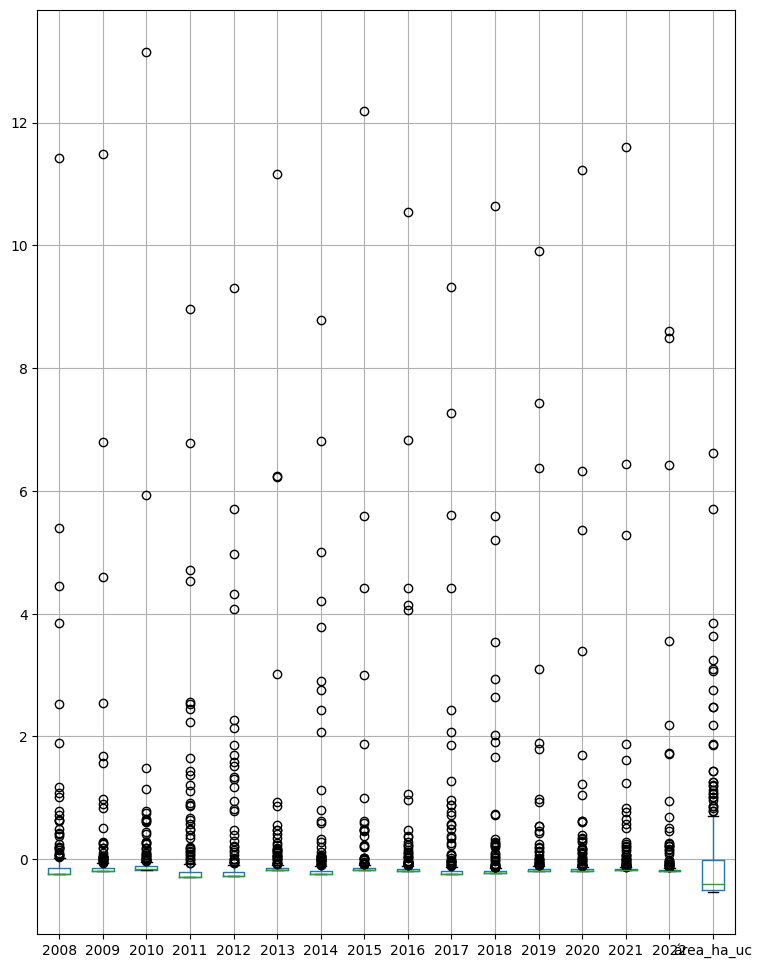

In [ ]:
df_norm.boxplot(figsize=(9,12))

Apesar de ser possível fazer a normalização dos dados de cada coluna. O grupo não utilizou a versão normalizada do dataset, pois não foi identificada nenhuma utilidade em seu uso.

Uma das utilizadas seria a reposição de dados ausentes, que poderiam ser repostos pelo knn-inputer. Porém, pela particularidade da forma em que os dados ausentes estavam presentes, o grupo optou por usar outras técnicas para inputação de dados, tornando o knn-inputer irrelevante, e a normalização sem sentido.

### Detecção de outrliers e Limpeza de dados

Boxplot dos dados de desmatamento em cada ano. Os valores dos dados não são acumulativos, e sua unidade é Hectare (ha).

<Axes: >

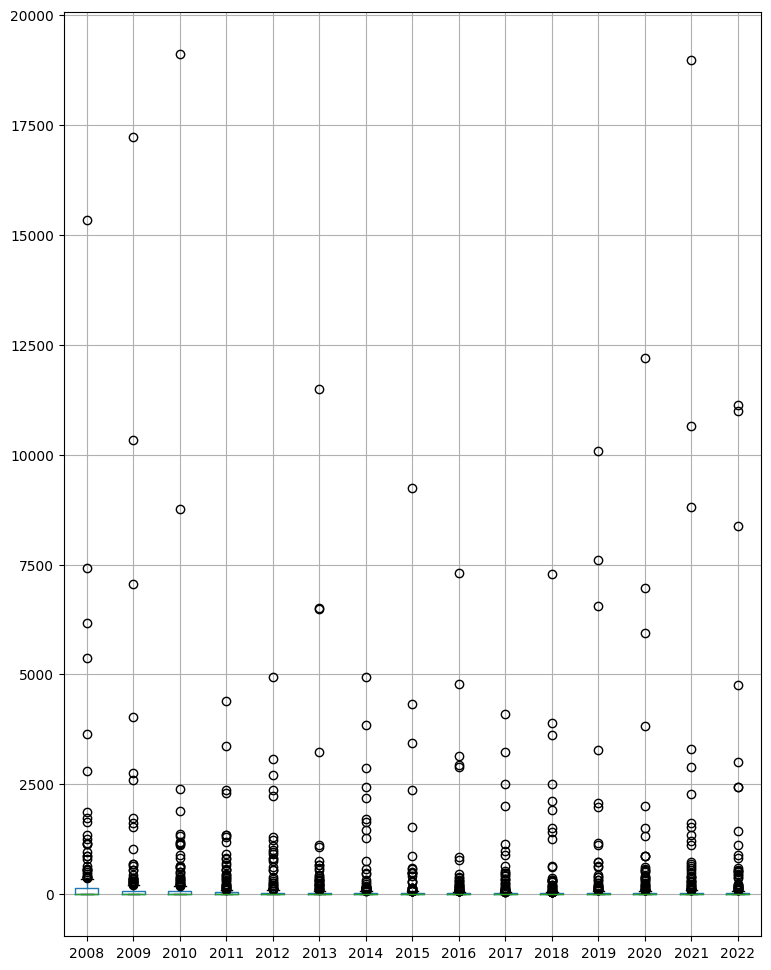

In [ ]:
df[range(2008,2023)].boxplot(figsize=(9,12))

Boxplot dos dados modificados. Ao invés de ser os dados puros de desmatamento, são as porcentagens da área desmatada de cada UC, ao longo dos anos. Dados não-acumulativos.

<Axes: >

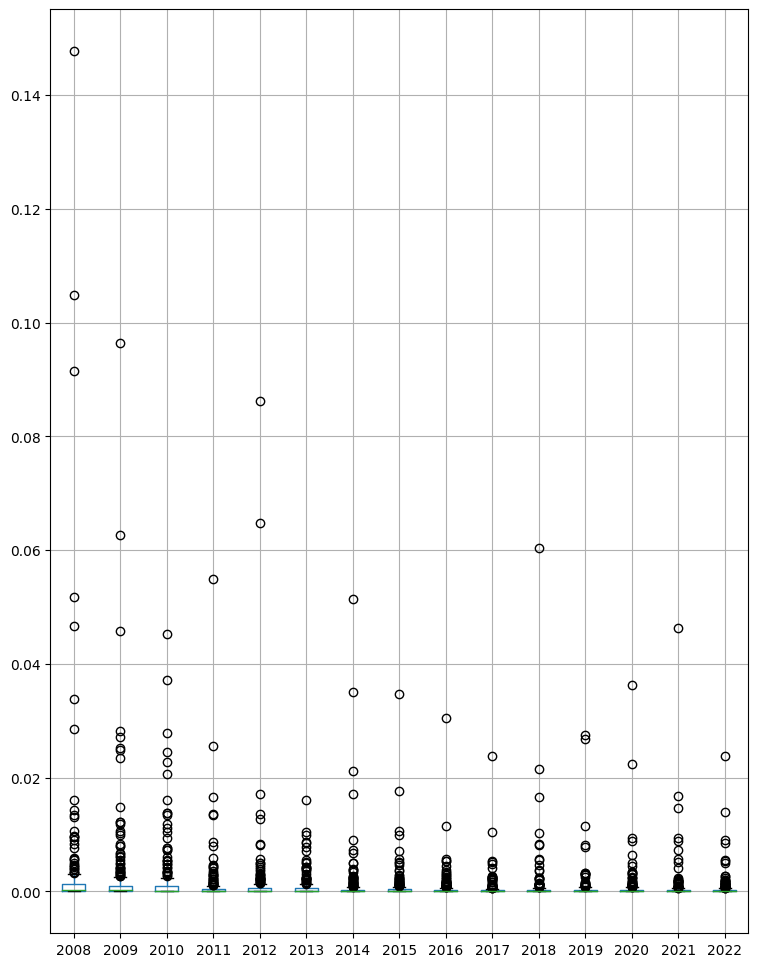

In [ ]:
dft = df.copy()
dft.loc[:,range(2008,2023)] = dft.loc[:,range(2008,2023)].apply(lambda x: x/dft['área_ha_uc'])
dft[range(2008,2023)].boxplot(figsize=(9,12))

Os boxplots apresentados mostram claramente vários outliers presentes no dataset, porém, contrário do que normalmente se pensaria, esses dados são relevantes e não devem ser excluídos do dataset.

As UCs possuem tamanhos muito diferentes, além de que a maioria das UCs não possuem uma área de milhares de hectares, que é o caso de certas UCs localizadas na Amazônia. Portanto, mesmo sendo consideradas como outliers, essas Unidades de Conservação não devem ser retiradas do dataset, pois elas ainda são importantes para a análise dos dados. De qualquer forma, é importante que quem esteja vendo as análises sendo feitas aqui, tenha essa informação em mente.

### Estatísticas descritivas dos dados com visualizações
(plots para análise)

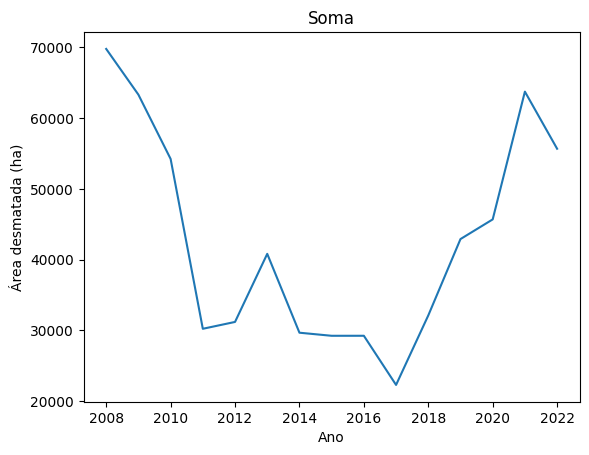

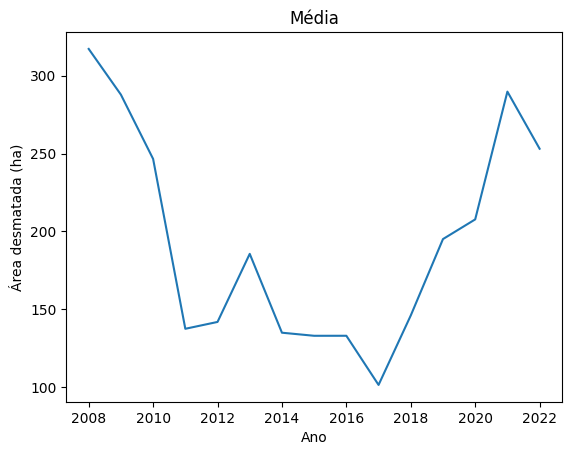

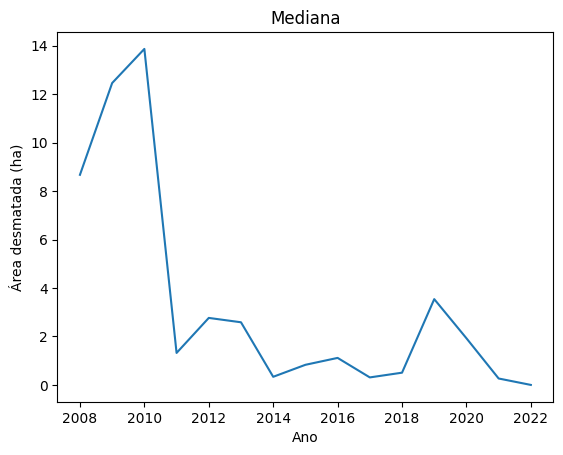

In [ ]:
cols = list(range(2008,2023))

plt.title('Soma')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].sum())
plt.show()

plt.title('Média')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].mean())
plt.show()

plt.title('Mediana')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].median())
plt.show()

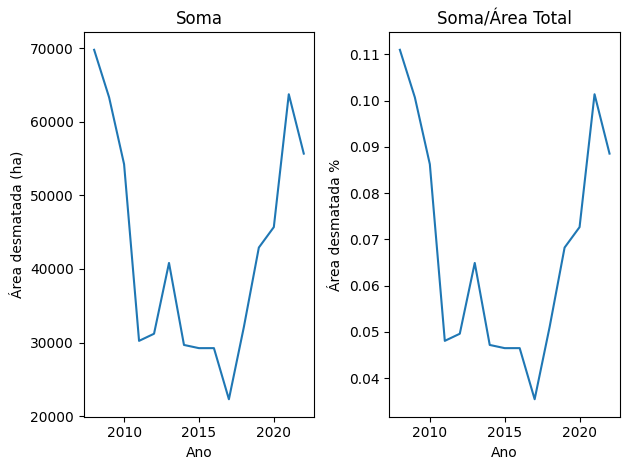

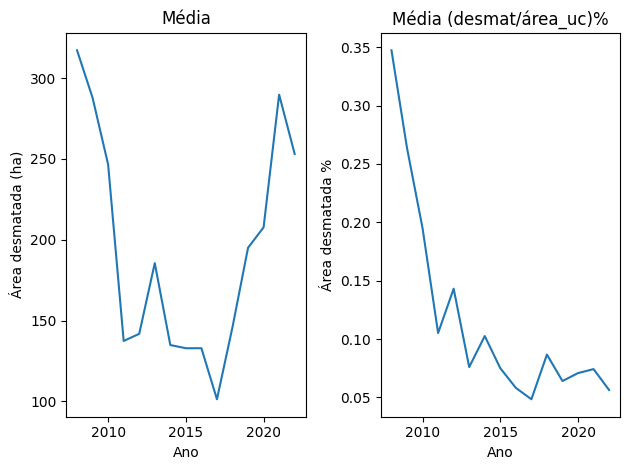

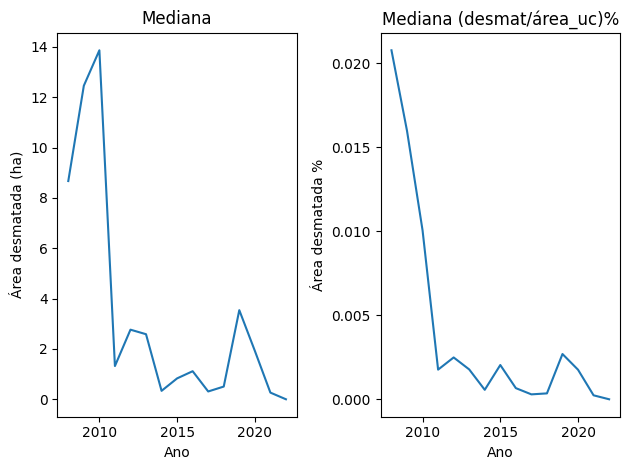

In [ ]:
plt.subplot(1, 2, 1)
plt.title('Soma')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].sum())

plt.subplot(1, 2, 2)
plt.title('Soma/Área Total')
plt.xlabel('Ano')
plt.ylabel('Área desmatada %')
plt.plot(((df[cols]/df['área_ha_uc'].sum()).sum())*100)
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.title('Média')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].mean())

plt.subplot(1, 2, 2)
plt.title('Média (desmat/área_uc)%')
plt.xlabel('Ano')
plt.ylabel('Área desmatada %')
plt.plot((dft[cols].mean())*100)
plt.tight_layout()
plt.show()

plt.subplot(1, 2, 1)
plt.title('Mediana')
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.plot(df[cols].median())

plt.subplot(1, 2, 2)
plt.title('Mediana (desmat/área_uc)%')
plt.xlabel('Ano')
plt.ylabel('Área desmatada %')
plt.plot((dft[cols].median())*100)
plt.tight_layout()
plt.show()

In [ ]:
df.describe()

área_ha_uc          2008          2009          2010         2011  \
count  2.200000e+02    220.000000    220.000000    220.000000   220.000000   
mean   2.858424e+05    317.171682    287.801545    246.524409   137.433977   
std    5.417177e+05   1318.053681   1478.608911   1436.805255   477.048777   
min    8.918946e+01      0.000000      0.000000      0.000000     0.000000   
25%    1.126207e+04      0.000000      0.000000      0.000000     0.000000   
50%    6.754204e+04      8.670000     12.457500     13.865000     1.320000   
75%    2.790140e+05    137.987500     81.065000     78.360000    41.701250   
max    3.865169e+06  15344.820000  17225.680000  19106.540000  4403.495000   

              2012          2013         2014         2015         2016  \
count   220.000000    220.000000   220.000000   220.000000   220.000000   
mean    141.828227    185.556909   134.912636   132.934023   132.945182   
std     516.549560   1014.786521   547.484841   750.120562   682.176215   
min       0.000000      0.000000     0.000000     0.000000     0.000000   
25%       0.000000      0.000000     0.000000     0.000000     0.000000   
50%       2.765000      2.585000     0.335000     0.830000     1.115000   
75%      37.013750     34.535000    31.337500    26.416250    27.122500   
max    4938.450000  11482.350000  4934.850000  9250.500000  7305.890000   

              2017         2018          2019          2020          2021  \
count   220.000000   220.000000    220.000000    220.000000    220.000000   
mean    101.376864   146.006091    195.052136    207.681818    289.740136   
std     430.944896   671.759392    999.359699   1070.669826   1613.968412   
min       0.000000     0.000000      0.000000      0.000000      0.000000   
25%       0.000000     0.000000      0.000000      0.000000      0.000000   
50%       0.310000     0.505000      3.540000      1.925000      0.265000   
75%      20.602500    21.912500     34.835000     37.115000     35.690000   
max    4106.880000  7280.340000  10073.500000  12198.600000  18982.120000   

               2022  
count    220.000000  
mean     253.066136  
std     1267.788918  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       30.770000  
max    11140.010000

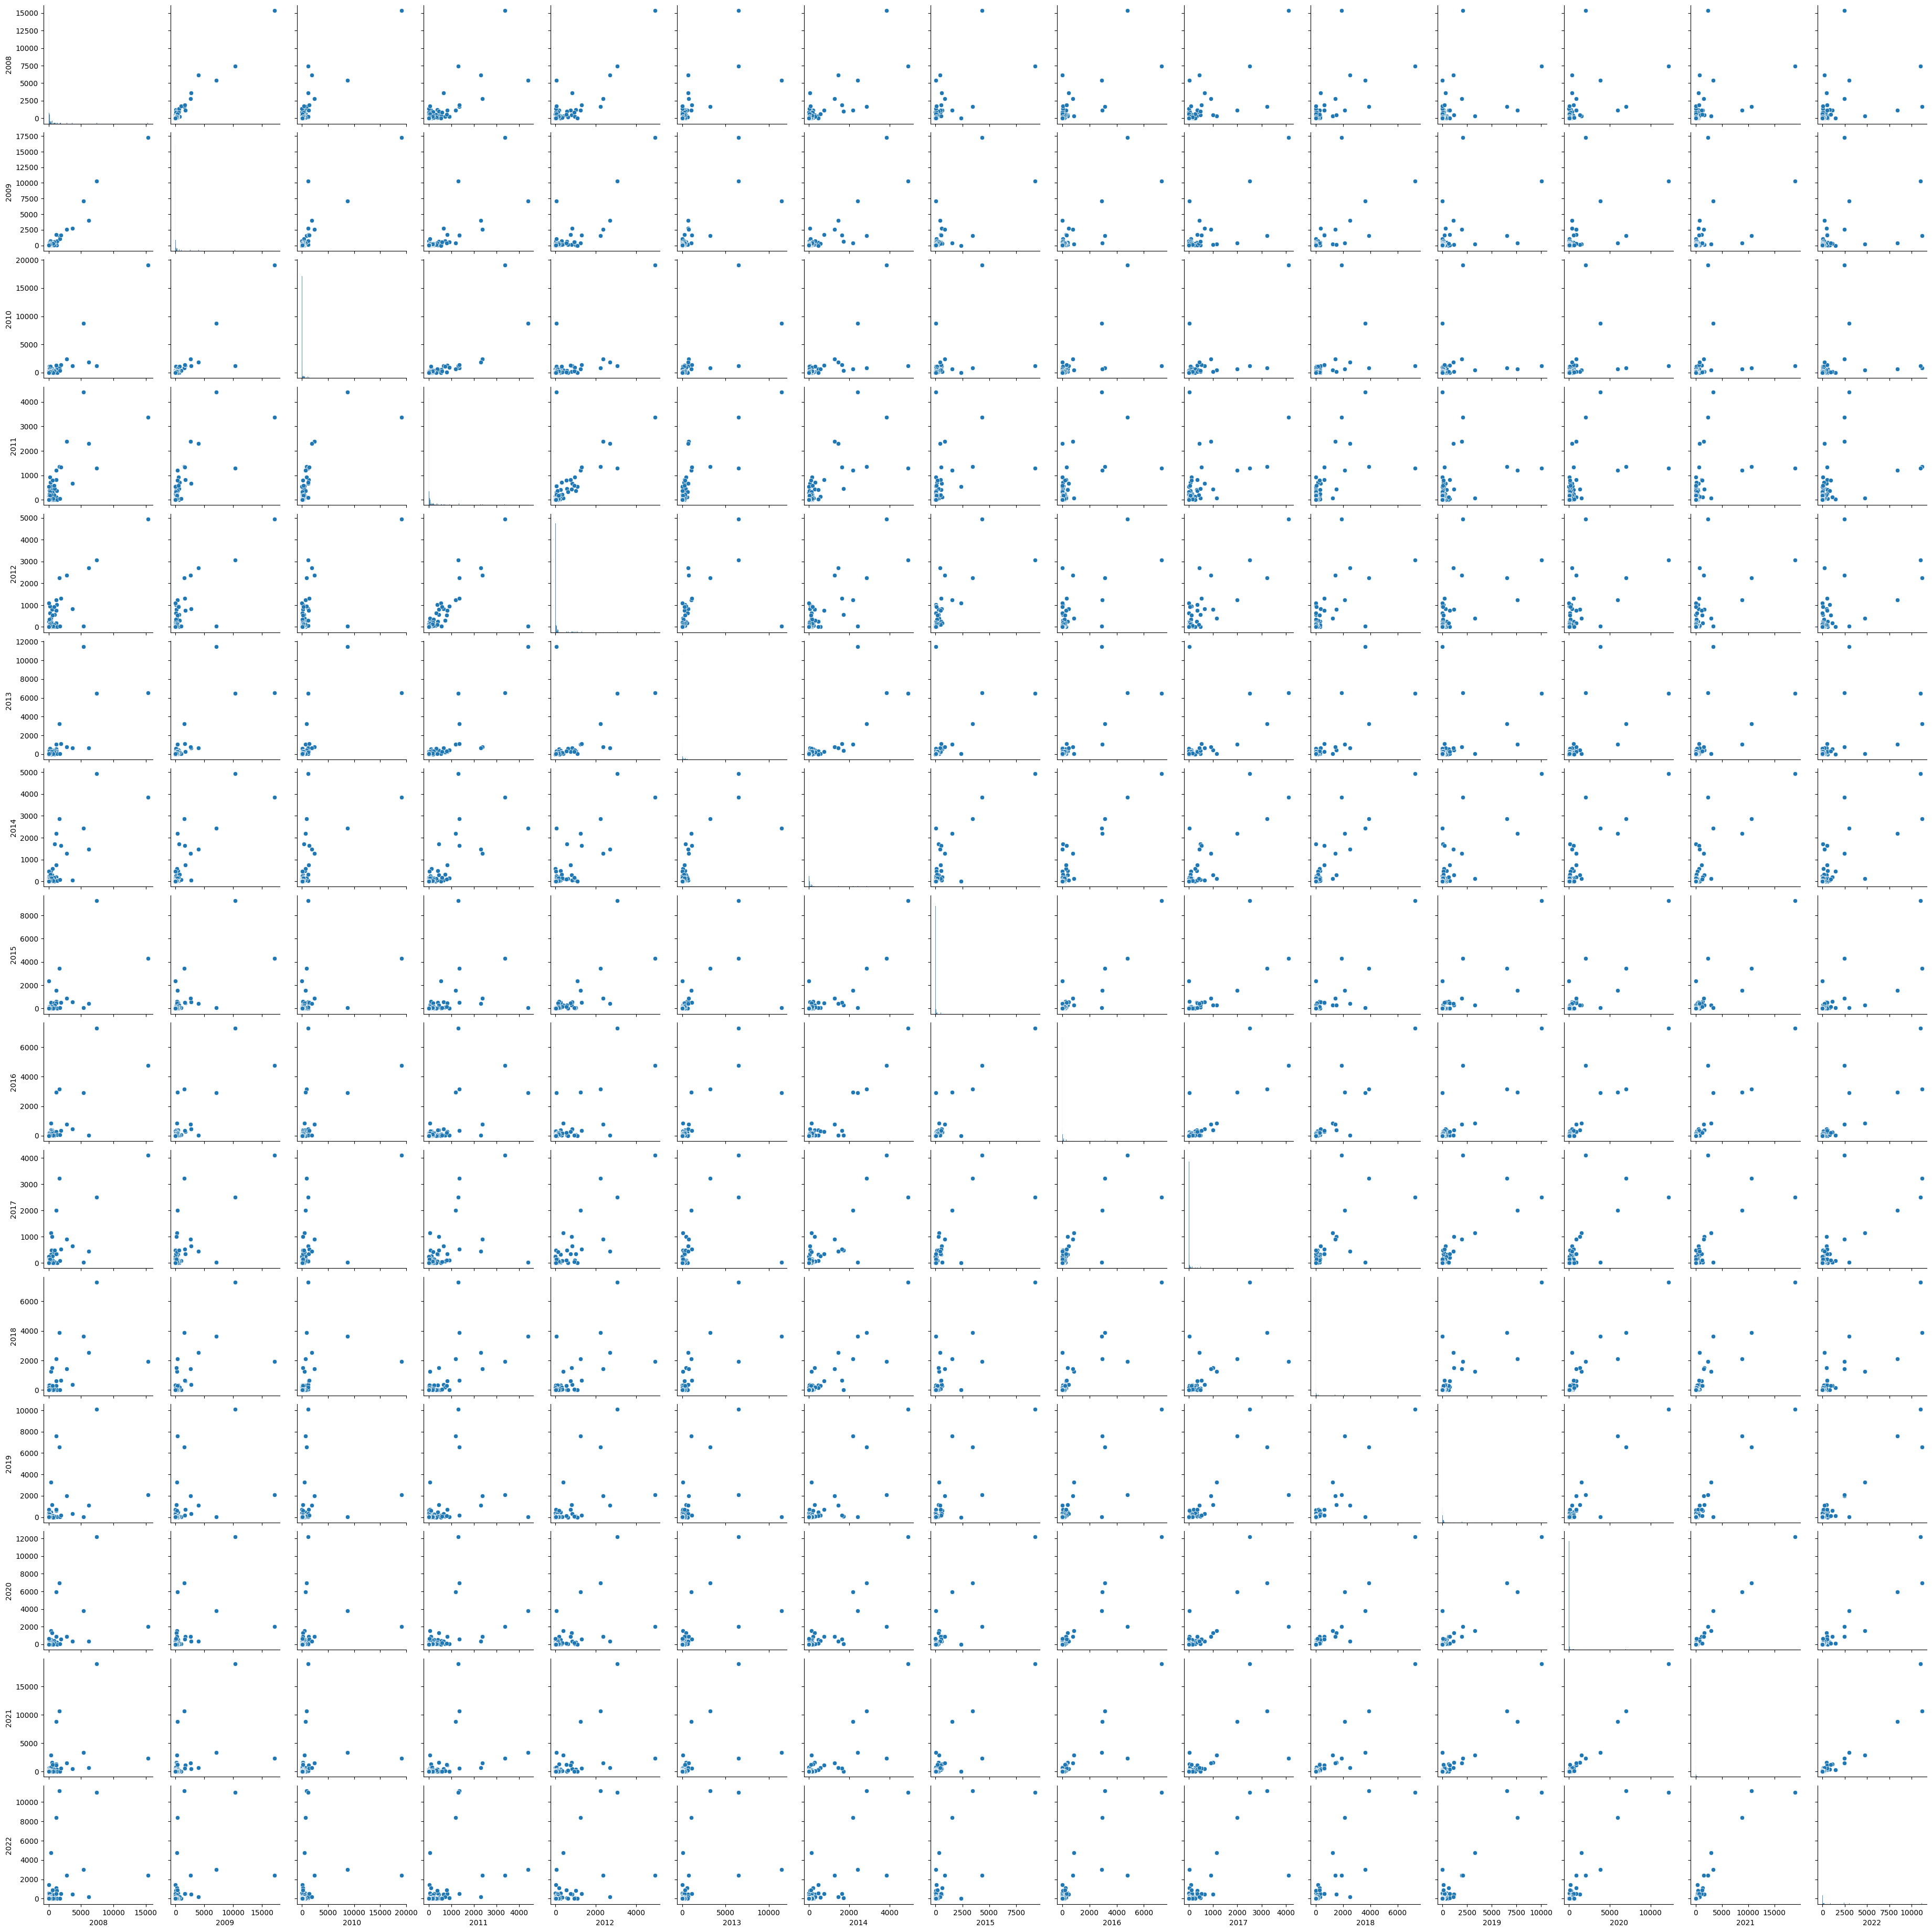

In [ ]:
sns.pairplot(df[cols])

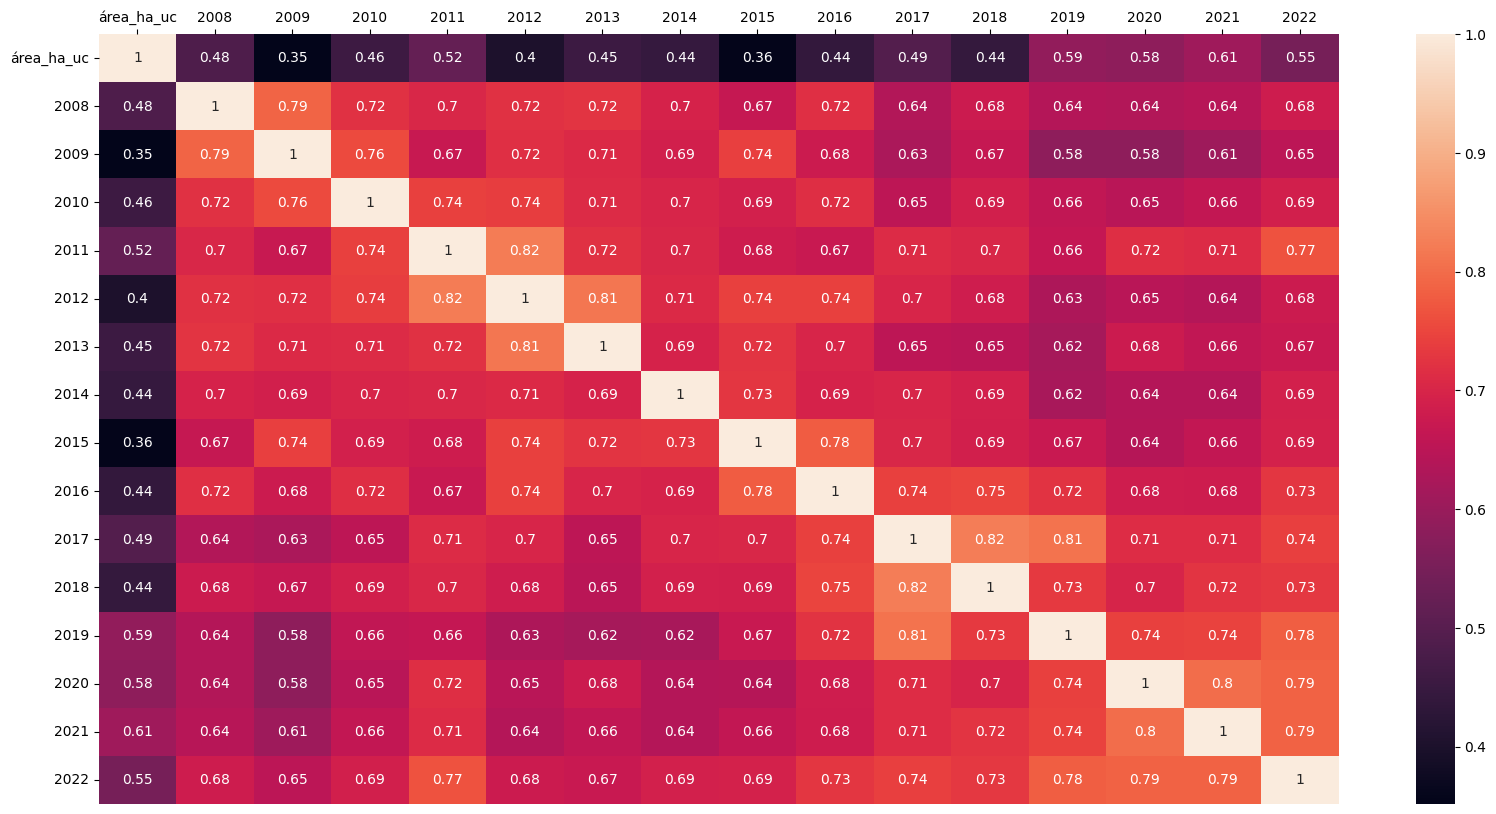

In [ ]:
plt.figure(figsize=(20,10))
hm = sns.heatmap(df[['área_ha_uc'] + cols].corr(method='spearman'), annot=True)
hm.set(xlabel="", ylabel="")
hm.xaxis.tick_top()
plt.show()

Como esperado, a maioria das colunas são moderada/fortemente correlacionadas entre si. Além disso, parace ser que, o ano y no qual um ano x é mais correlacionado parece ser o ano seguinte.

E a que é geralmente menos correlacionada com outras é 'área_ha_uc', o que significa que o tamanho da UC de fato importa para a quantidade de seus hecctares desmatados, mas não tanto.

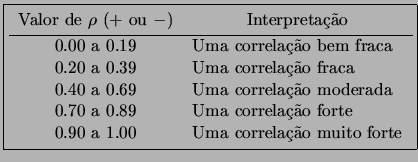

In [ ]:
for col in colsa:
  _, p = stats.shapiro(df[col].apply(lambda x: log10(x) if x!=0 else 0))
  print(f"{col}: {p:.9f}")

área_ha_uc: 0.000008510
2008: 0.000000002
2009: 0.000000192
2010: 0.000000001
2011: 0.000000000
2012: 0.000000000
2013: 0.000000000
2014: 0.000000000
2015: 0.000000000
2016: 0.000000000
2017: 0.000000000
2018: 0.000000000
2019: 0.000000000
2020: 0.000000000
2021: 0.000000000
2022: 0.000000000


Transformar os valores das colunas em log10 também não as ajuda a alcançar a distribuição gaussiana.

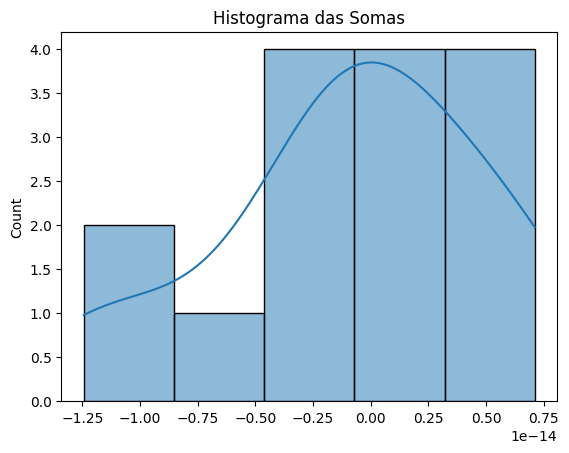

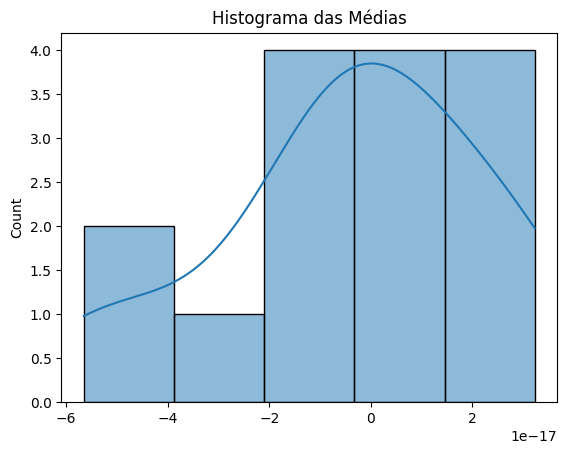

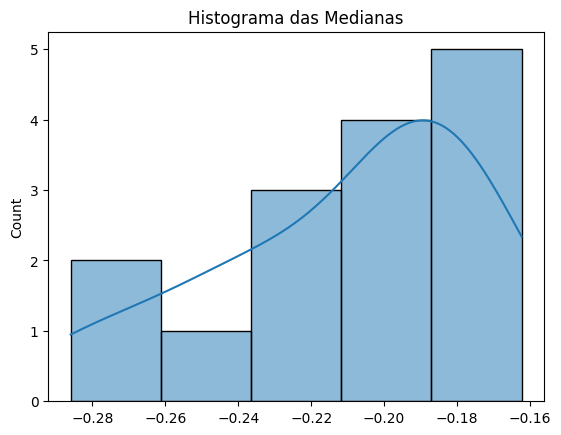

In [ ]:
sns.histplot(df_norm[cols].sum(), kde=True)
plt.title('Histograma das Somas')
plt.show()

# Histograma das médias
sns.histplot(df_norm[cols].mean(), kde=True)
plt.title('Histograma das Médias')
plt.show()

# Histograma das medianas
sns.histplot(df_norm[cols].median(), kde=True)
plt.title('Histograma das Medianas')
plt.show()

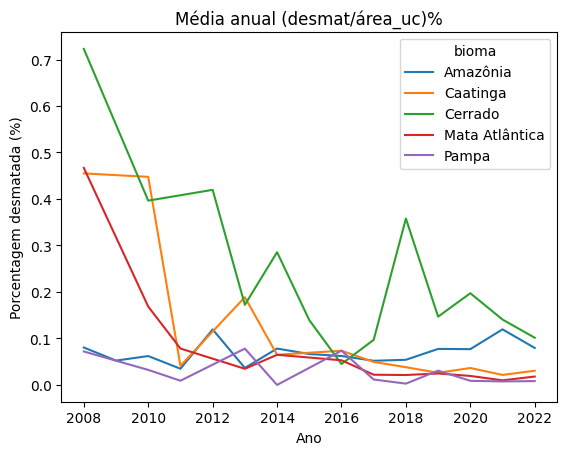

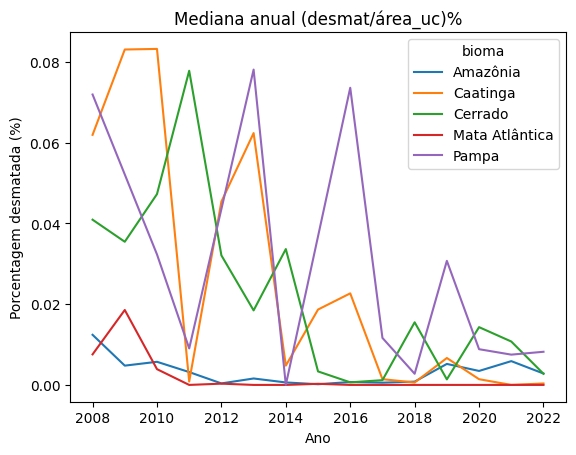

In [ ]:
colsb = cols + ['bioma']
grupobi = dft[colsb].groupby(by='bioma')

(grupobi.aggregate('mean')*100).T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Porcentagem desmatada (%)')
plt.title('Média anual (desmat/área_uc)%')

(grupobi.aggregate('median')*100).T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Porcentagem desmatada (%)')
plt.title('Mediana anual (desmat/área_uc)%');

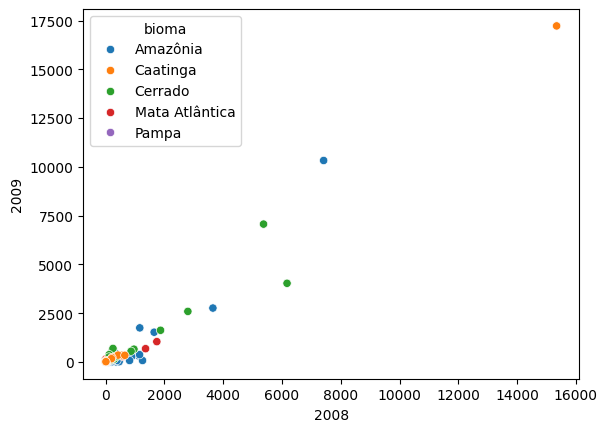

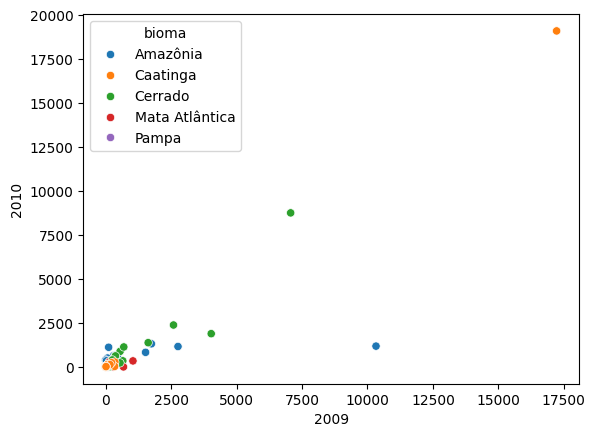

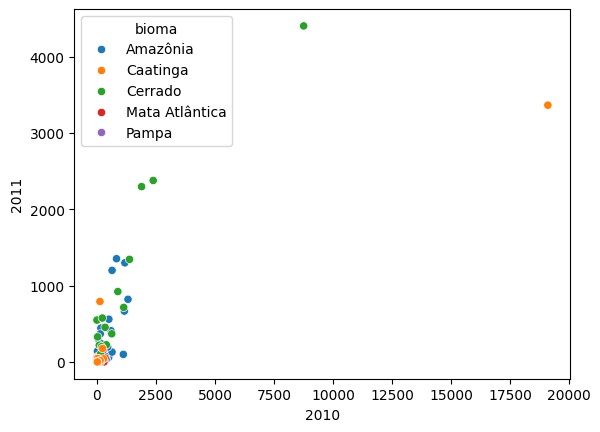

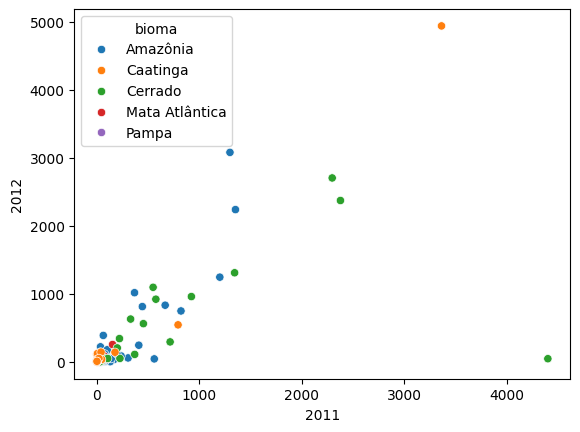

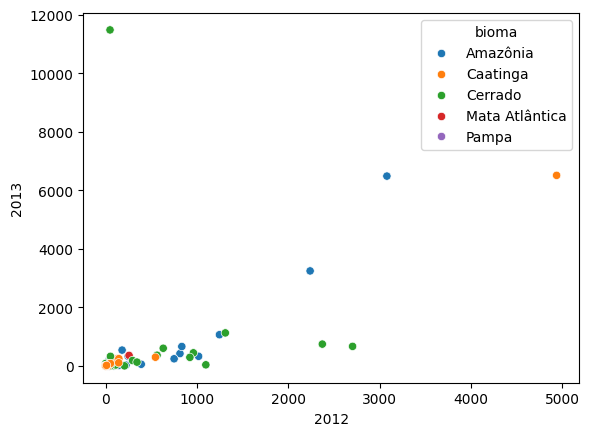

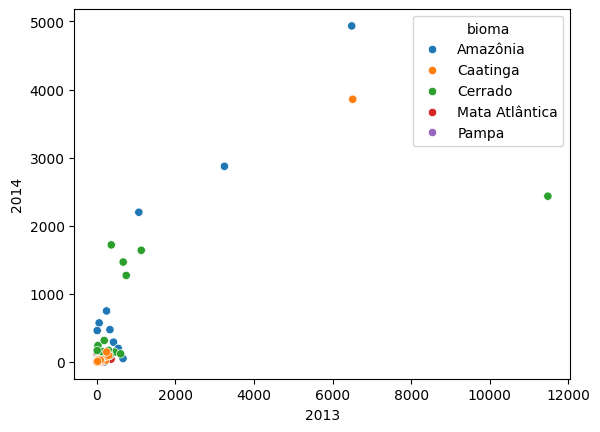

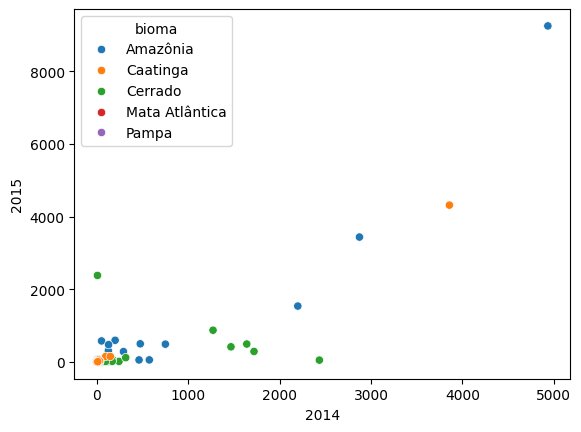

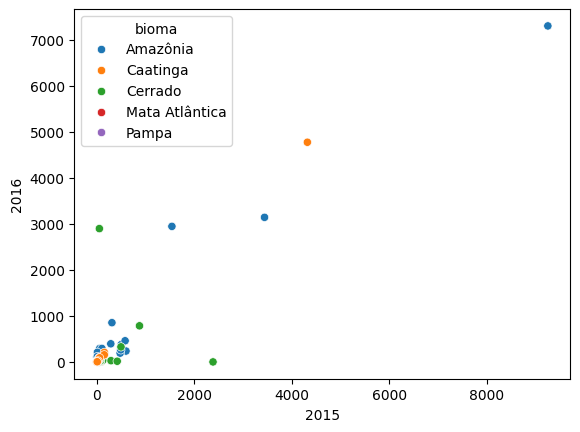

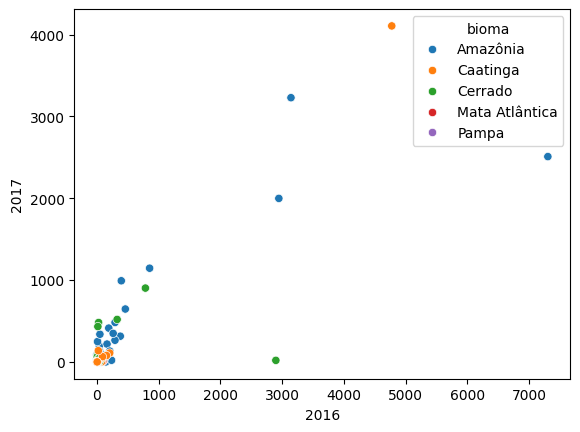

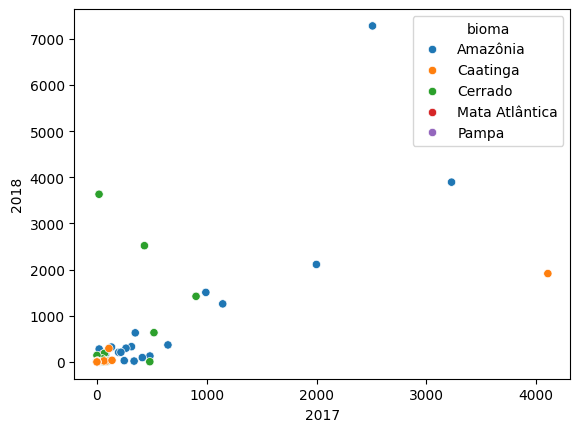

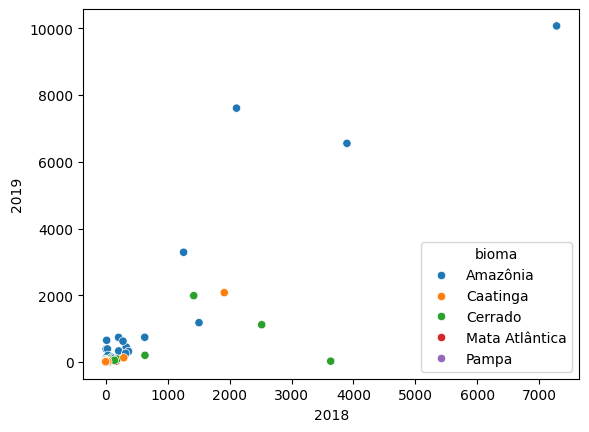

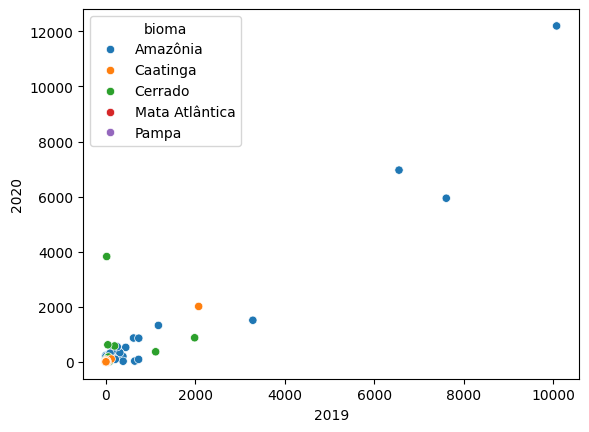

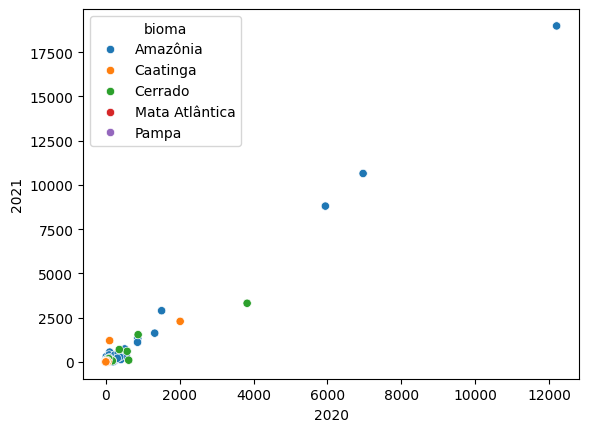

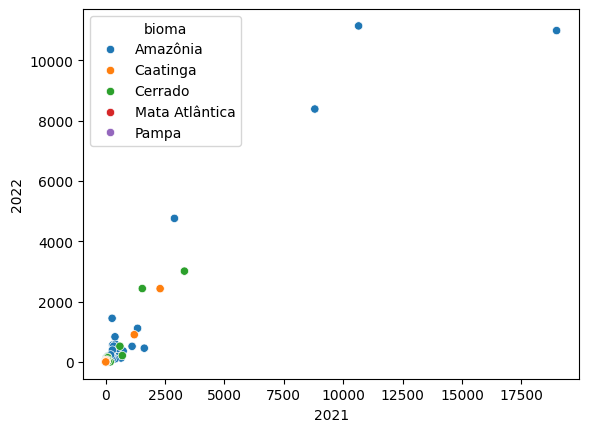

In [ ]:
for ano in range(2008, 2022):
  sns.scatterplot(df, x=ano, y=(ano+1), hue='bioma')
  plt.show()

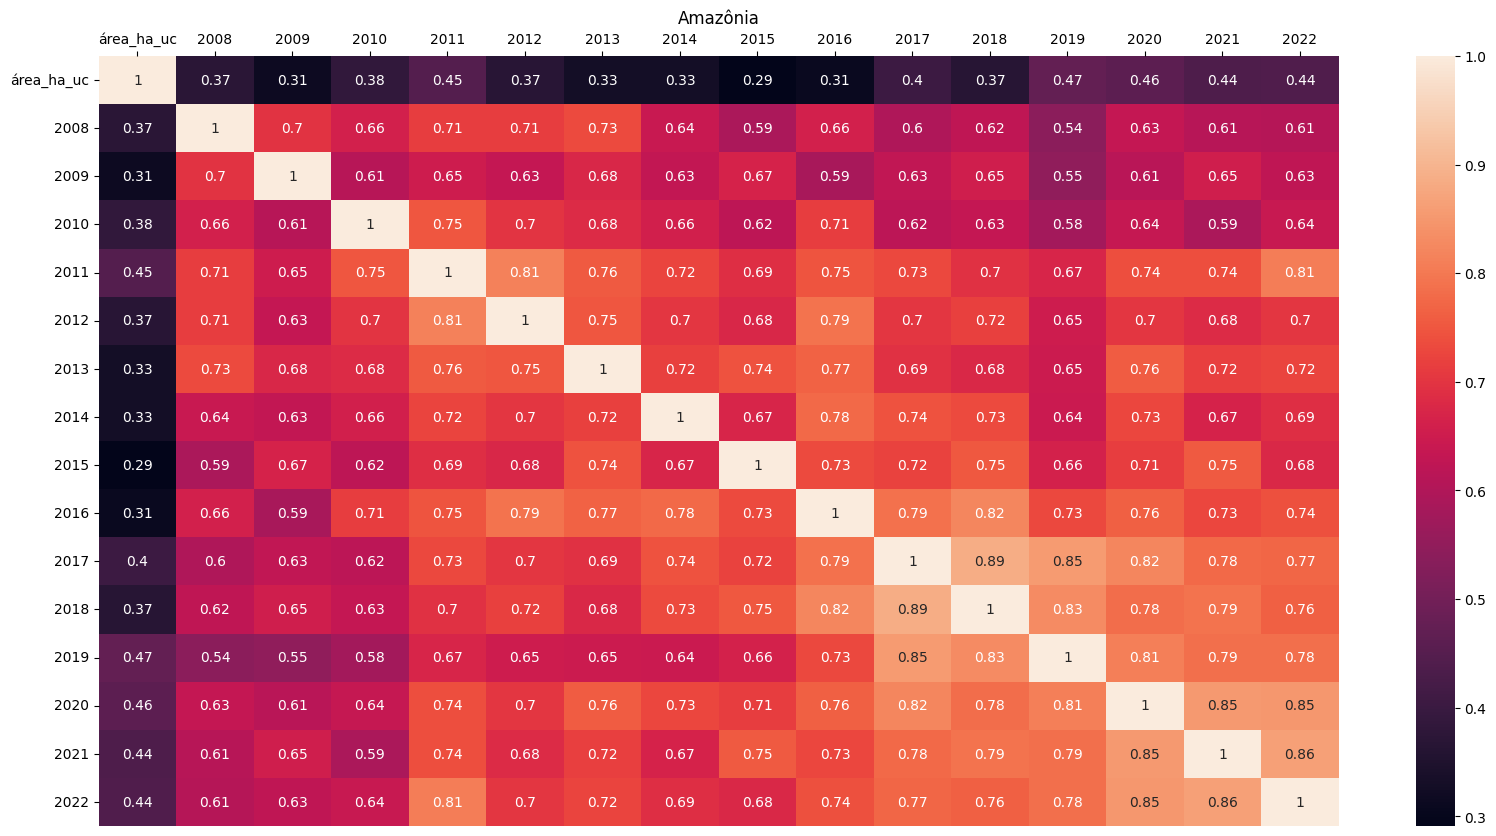

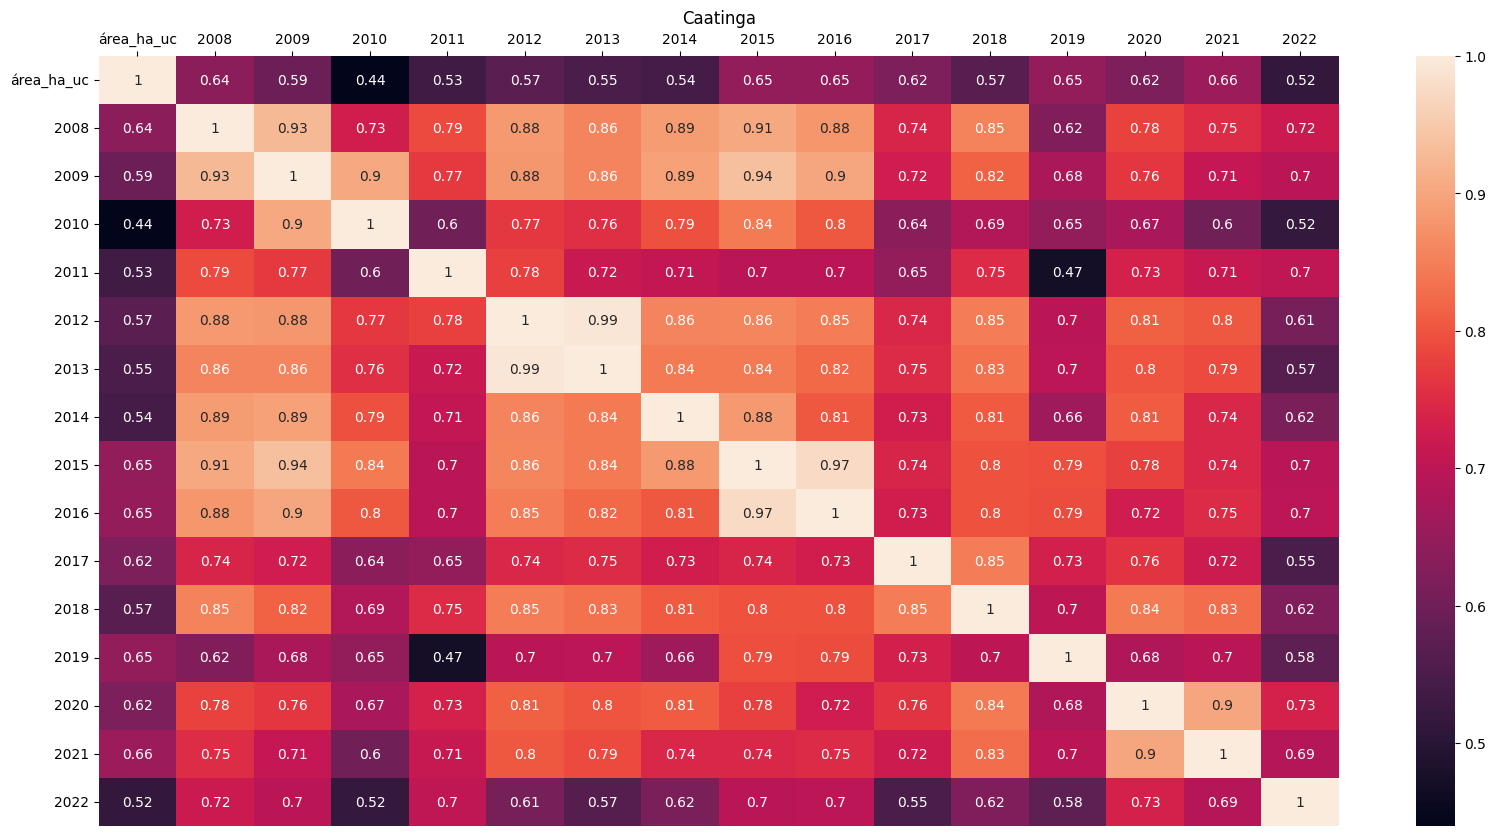

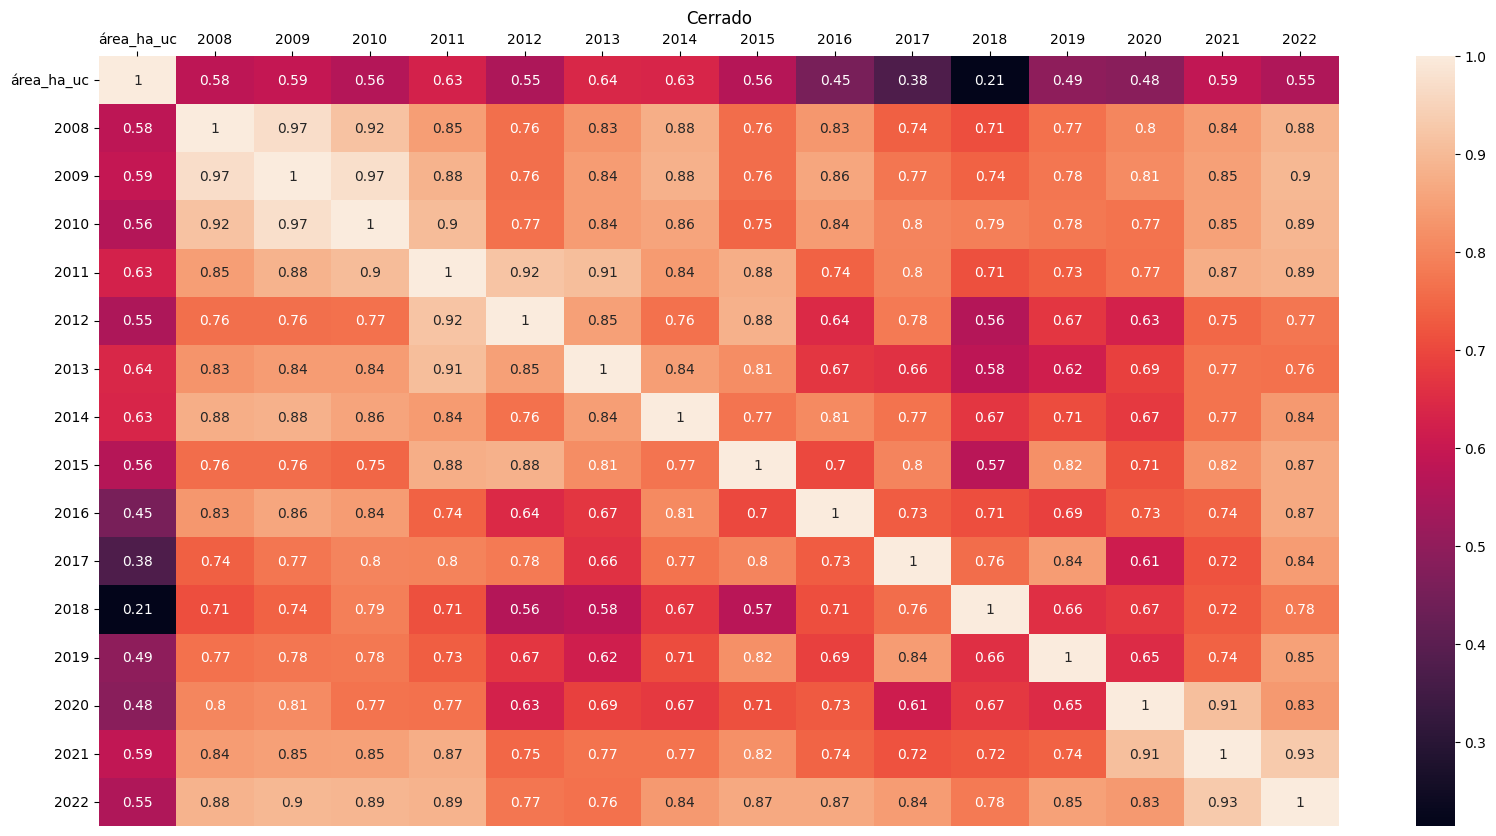

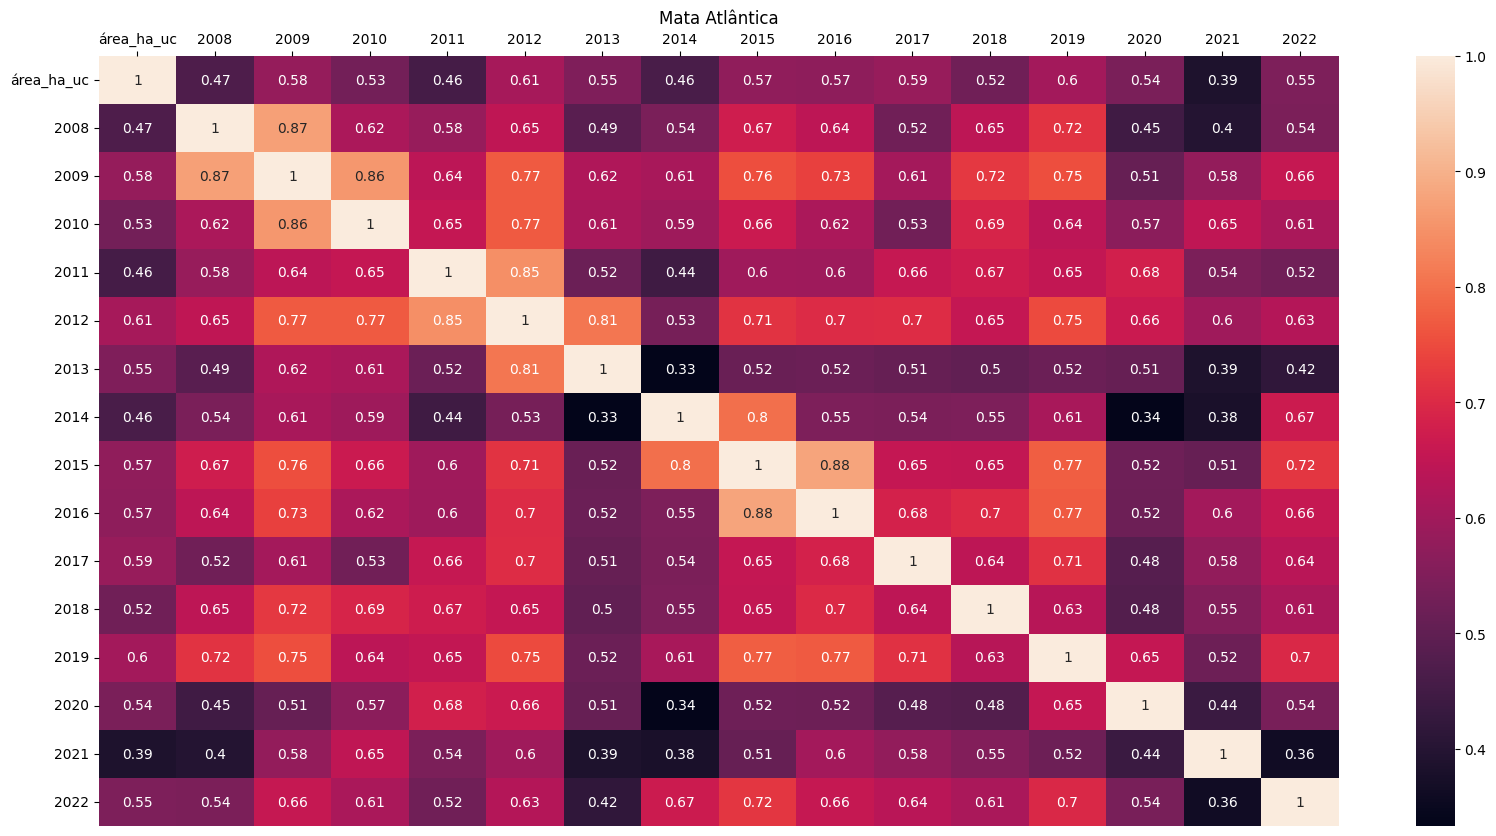

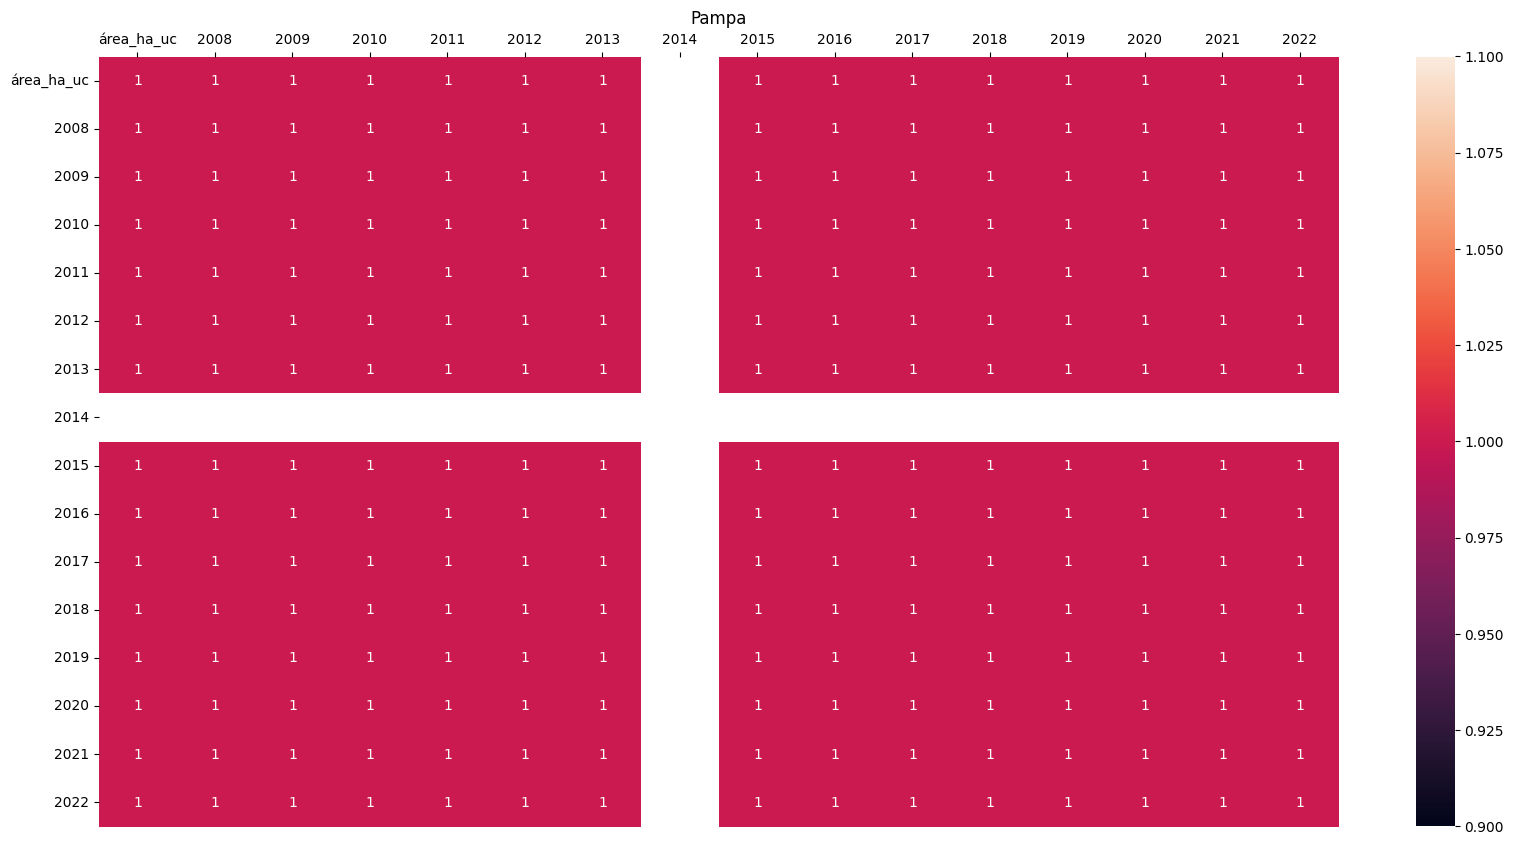

In [ ]:
for b in df.bioma.cat.categories:
  plt.figure(figsize=(20,10))
  hm = sns.heatmap(df.loc[(df.bioma==b),(['área_ha_uc'] + cols)].corr(method='spearman'), annot=True)
  hm.set(xlabel="", ylabel="", title=b)
  hm.xaxis.tick_top()
  plt.show()

O bioma da Pampa apresentou esta correlação porque o dataset só possui duas UCs localizadas nesse bioma.

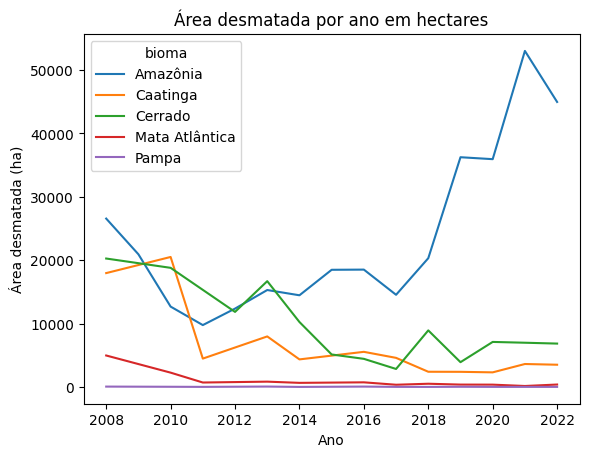

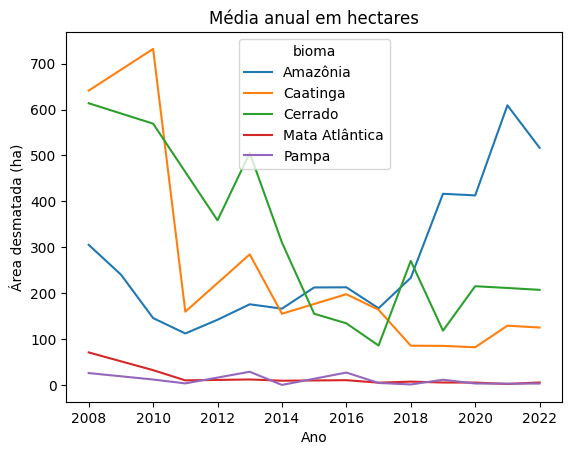

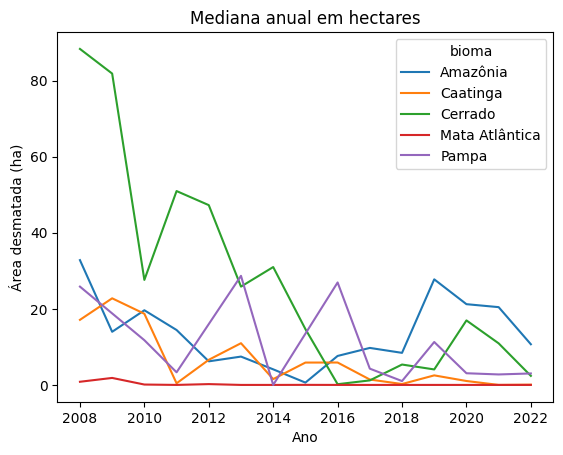

In [ ]:
grupobi = df[colsb].groupby(by='bioma')
#sns.lineplot(df[colsb].groupby(by='bioma').aggregate('mean').T)

grupobi.aggregate('sum').T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.title('Área desmatada por ano em hectares')

grupobi.aggregate('mean').T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.title('Média anual em hectares')

grupobi.aggregate('median').T.plot.line()
plt.xlabel('Ano')
plt.ylabel('Área desmatada (ha)')
plt.title('Mediana anual em hectares');

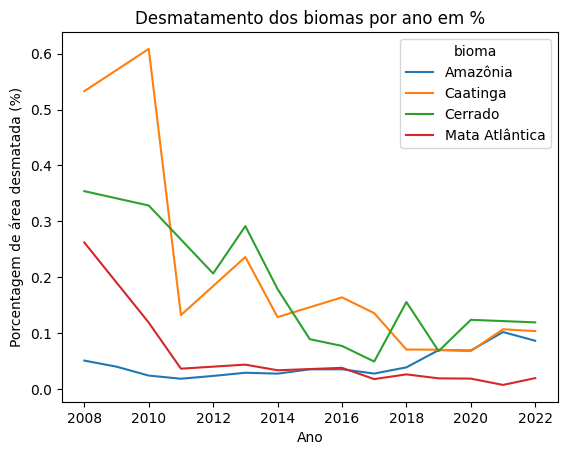

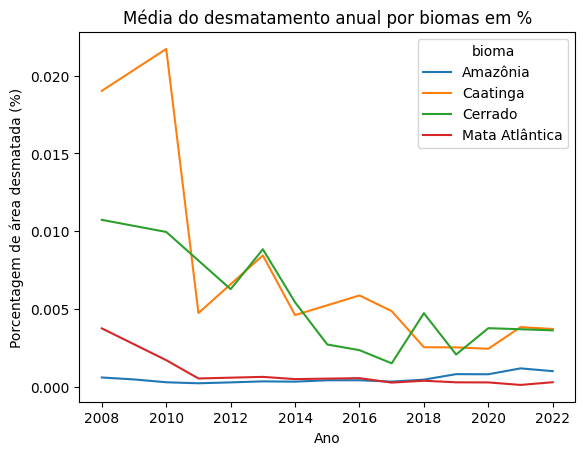

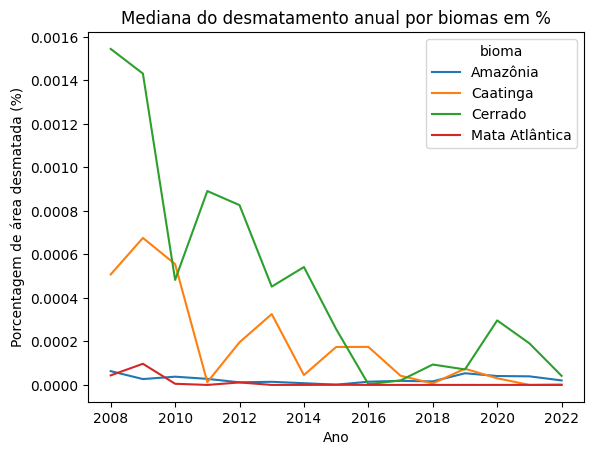

In [ ]:
areasbi = np.array(df[['área_ha_uc', 'bioma']].groupby(by='bioma').aggregate('sum').T)
bms = ['Amazônia', 'Caatinga', 'Cerrado', 'Mata Atlântica']

((grupobi.aggregate('sum').T/areasbi)*100)[bms].plot.line()
plt.xlabel('Ano')
plt.ylabel('Porcentagem de área desmatada (%)')
plt.title('Desmatamento dos biomas por ano em %')

((grupobi.aggregate('mean').T/areasbi)*100)[bms].plot.line()
plt.xlabel('Ano')
plt.ylabel('Porcentagem de área desmatada (%)')
plt.title('Média do desmatamento anual por biomas em %')

((grupobi.aggregate('median').T/areasbi)*100)[bms].plot.line()
plt.xlabel('Ano')
plt.ylabel('Porcentagem de área desmatada (%)')
plt.title('Mediana do desmatamento anual por biomas em %');

### Testes de hipótese

In [ ]:
# só estou fazendo isso porque não paro de me confundir com o valor de pvalue
def hip_pvalue(pvalue, h0:str=None, h1:str=None, alpha:float=0.05):
  print(f"P-value: {pvalue}")
  if(pvalue < alpha):
    print("Hipótese nula rejeitada")
    if(h0 is not None):
      print(f"[INCORRETO] {h0}")
    print("Hipótese ALTERNATIVA não-rejeitada e (possivelmente?) aceita")
    if(h1 is not None):
      print(f"[CORRETO] {h1}")
  else:
    print("Hipótese NULA não-rejeitada e (possivelmente?) aceita")
    if(h0 is not None):
      print(f"[CORRETO] {h0}")
    print("Hipótese alternativa rejeitada")
    if(h1 is not None):
      print(f"[INCORRETO] {h1}")

**Mann-Whitney:**

hipótese nula:
* A diferença entre as distribuições de dois atributos não é significativa (não tem diferença)
* Se p-value for menor que 0.05, ela é rejeitada

hipótese alternativa:
* A diferença entre as distribuições de dois atributos não é significativa (tem diferença sim)
* Se p-value for maior que 0.05, ela é rejeitada

<Axes: xlabel='bioma'>

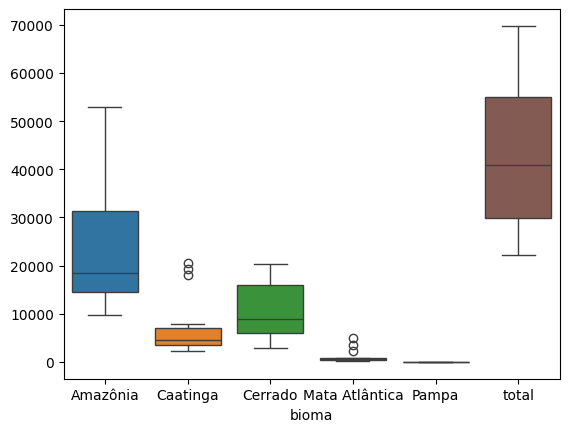

In [ ]:
grupobi = df[colsb].groupby(by='bioma').aggregate('sum').T
sns.boxplot(data=(grupobi.assign(total=df[cols].sum())))

Hipótese nula: Não há uma diferença significativa entre o desmatamento em UCs na Amazônia e Cerrado, e entre de todas as UCs

Hipótese alternativa: Há uma diferença significativa

<Axes: >

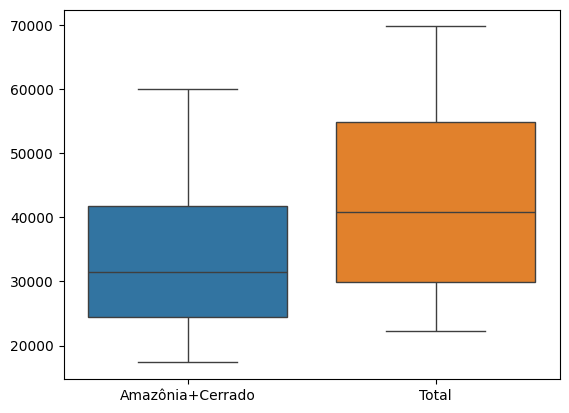

In [ ]:
am = grupobi['Amazônia'] + grupobi['Cerrado']
amc_total = pd.DataFrame({"Amazônia+Cerrado": am, "Total": df[cols].sum()})
sns.boxplot(data=amc_total)

In [ ]:
_, p = stats.mannwhitneyu(amc_total["Amazônia+Cerrado"], amc_total['Total'])
hip_pvalue(p, "Não há uma diferença significativa entre o desmatamento em UCs na Amazônia e Cerrado, e entre o de todas as UCs", "Há uma diferença significativa")

P-value: 0.10573920209087935
Hipótese NULA não-rejeitada e (possivelmente?) aceita
[CORRETO] Não há uma diferença significativa entre o desmatamento em UCs na Amazônia e Cerrado, e entre o de todas as UCs
Hipótese alternativa rejeitada
[INCORRETO] Há uma diferença significativa


Logo podemos assumir que o desmatamento total em UCs no Brasil são bem representadas pela amostra: desmatamento conjunto de UCs localizadas na Amazônia e Cerrado

---



In [ ]:
_, p = stats.mannwhitneyu(grupobi['Amazônia'],grupobi['Caatinga'])
hip_pvalue(p)

P-value: 0.0002228932910846752
Hipótese nula rejeitada
Hipótese ALTERNATIVA não-rejeitada e (possivelmente?) aceita


In [ ]:
_, p = stats.mannwhitneyu(grupobi['Amazônia'],grupobi['Cerrado'])
hip_pvalue(p)

P-value: 0.0021450570245935504
Hipótese nula rejeitada
Hipótese ALTERNATIVA não-rejeitada e (possivelmente?) aceita


In [ ]:
_, p = stats.mannwhitneyu(grupobi['Caatinga'],grupobi['Cerrado'])
hip_pvalue(p)

P-value: 0.06799575043506911
Hipótese NULA não-rejeitada e (possivelmente?) aceita
Hipótese alternativa rejeitada



---

**Wilcoxon:**

In [ ]:
mandatos = pd.DataFrame()
mandatos['lula'] = df[[2008, 2009, 2010]].sum(axis=1)
mandatos['dilma'] = df[range(2011, 2017)].sum(axis=1)
mandatos['temer'] = df[[2017, 2018]].sum(axis=1)
mandatos['bolsonaro'] = df[range(2019, 2023)].sum(axis=1)
mandatos = mandatos.assign(dilma_temer= mandatos['dilma']+mandatos['temer'])
mandatos.head()

lula1     dilma    temer  bolsonaro  dilma_temer
0   124.68     10.72     0.00      55.53        10.72
1  4002.22  16292.27  7124.81   35302.63     23417.08
2    28.85     28.11    38.02      90.63        66.13
3    67.08    583.62   116.43     309.10       700.05
4    47.86      0.00     0.00     230.78         0.00

<Axes: >

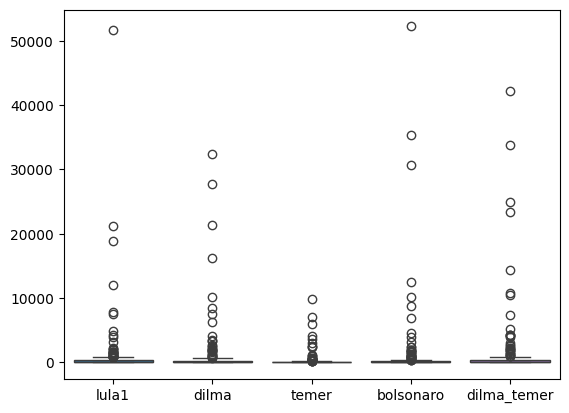

In [ ]:
sns.boxplot(data=mandatos)

In [ ]:
_, p = stats.wilcoxon(mandatos['dilma_temer'], mandatos['bolsonaro'])
hip_pvalue(p, "Não houve diferença significativa entre os índices de desmatamento, em UCs, entre os governos dilma+temer e bolsonaro", "Houve sim uma diferença entre os mandatos")

P-value: 2.27433241062649e-07
Hipótese nula rejeitada
[INCORRETO] Não houve diferença significativa entre os índices de desmatamento, em UCs, entre os governos dilma+temer e bolsonaro
Hipótese ALTERNATIVA não-rejeitada e (possivelmente?) aceita
[CORRETO] Houve sim uma diferença entre os mandatos


---

 Agora vamos usar o teste de **Wilcoxon** para comparar os períodos de lula/Dilma com Temer/Bolsonaro, e ver se houve alguma mudanca significativa.

Hipótese Nula (H0): O desmatamento médio anual no Brasil durante os mandatos de Lula e Dilma é igual ao desmatamento médio anual durante os mandatos de Temer e Bolsonaro.

Hipótese Alternativa (H1): O desmatamento médio anual no Brasil durante os mandatos de Lula e Dilma é diferente do desmatamento médio anual durante os
mandatos de Temer e Bolsonaro.



In [ ]:
# Somar os dados de desmatamento para Lula/Dilma e Temer/Bolsonaro
lula_dilma = mandatos['lula'] + mandatos['dilma']
temer_bolsonaro = mandatos['temer'] + mandatos['bolsonaro']


# Realizar o Wilcoxon test
statistic, p_value = wilcoxon(lula_dilma, temer_bolsonaro)
alpha = 0.05

print(f"Estatística: {statistic}")
print(f"p-valor: {p_value}")

if p_value < alpha:
    print("Rejeitamos a hipótese nula. O desmatamento foi significativamente diferente entre os períodos.")
else:
    print("Não rejeitamos a hipótese nula. Não há evidências suficientes para afirmar que o desmatamento foi significativamente diferente entre os períodos.")

Estatística: 4415.0
p-valor: 1.0141134091850885e-11
Rejeitamos a hipótese nula. O desmatamento foi significativamente diferente entre os períodos.


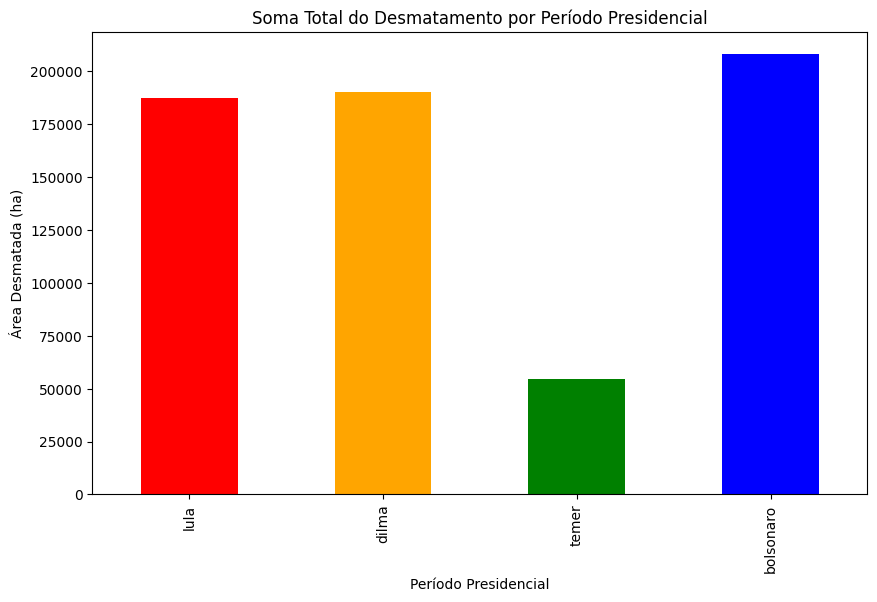

<ipython-input-245-c3983cce2269>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Período Presidencial', y='Desmatamento', data=mandatos_melted, palette='Set3')


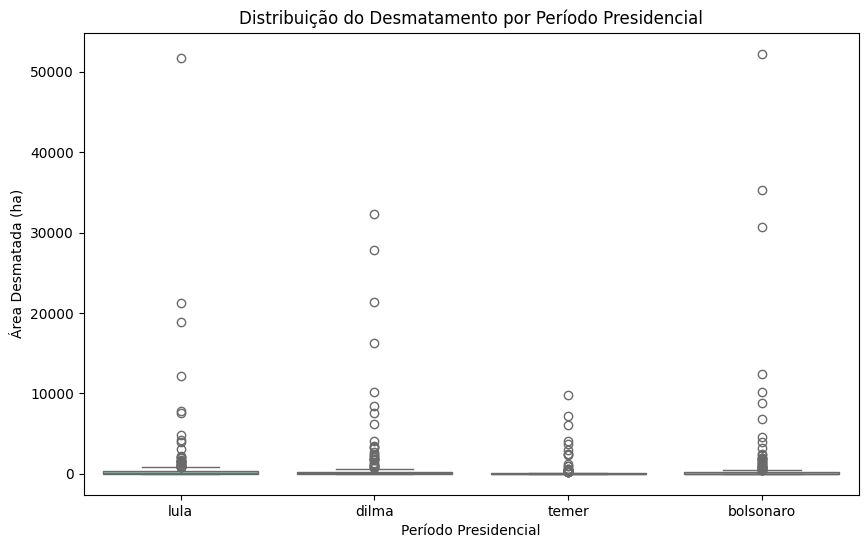

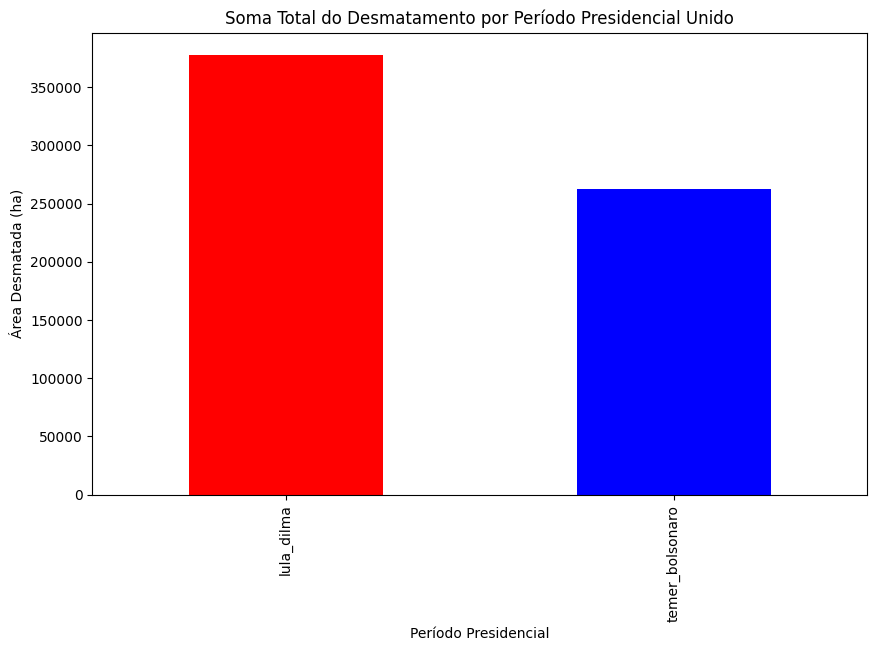

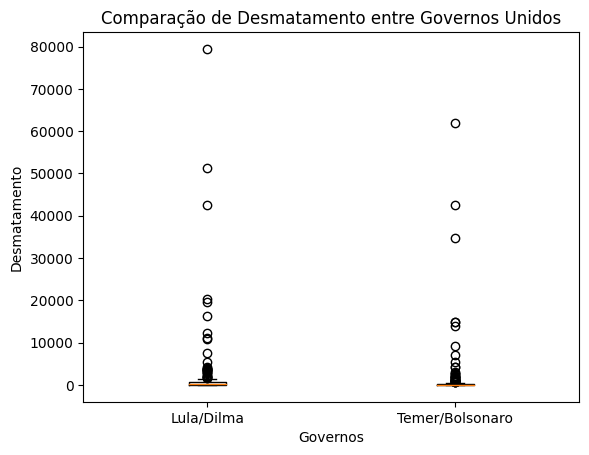

In [245]:
# Gráfico de barras da soma total do desmatamento em cada período
mandatos_sum = mandatos[['lula', 'dilma', 'temer', 'bolsonaro']].sum()
mandatos_sum.plot(kind='bar', figsize=(10, 6), color=['red', 'orange', 'green', 'blue'])
plt.title('Soma Total do Desmatamento por Período Presidencial')
plt.ylabel('Área Desmatada (ha)')
plt.xlabel('Período Presidencial')
plt.show()

# Preparar dados para o boxplot
mandatos_melted = pd.melt(mandatos, value_vars=['lula', 'dilma', 'temer', 'bolsonaro'],
                          var_name='Período Presidencial', value_name='Desmatamento')

# Boxplot comparando a distribuição do desmatamento entre os períodos
plt.figure(figsize=(10, 6))
sns.boxplot(x='Período Presidencial', y='Desmatamento', data=mandatos_melted, palette='Set3')
plt.title('Distribuição do Desmatamento por Período Presidencial')
plt.ylabel('Área Desmatada (ha)')
plt.xlabel('Período Presidencial')
plt.show()

mandatos_junto = pd.DataFrame()
mandatos_junto['lula_dilma'] = lula_dilma
mandatos_junto['temer_bolsonaro'] = temer_bolsonaro

# Gráfico de barras da soma total do desmatamento em cada período
mandatos_sum = mandatos_junto[['lula_dilma', 'temer_bolsonaro']].sum()
mandatos_sum.plot(kind='bar', figsize=(10, 6), color=['red', 'blue'])
plt.title('Soma Total do Desmatamento por Período Presidencial Unido')
plt.ylabel('Área Desmatada (ha)')
plt.xlabel('Período Presidencial')
plt.show()

# Criar um boxplot
plt.boxplot(mandatos_junto, labels=['Lula/Dilma', 'Temer/Bolsonaro'])

# Adicionar título e rótulos aos eixos
plt.title('Comparação de Desmatamento entre Governos Unidos')
plt.xlabel('Governos')
plt.ylabel('Desmatamento')

# Exibir o gráfico
plt.show()



---

Agora testes de hipóteses com as regiões dessas UCs

<Axes: >

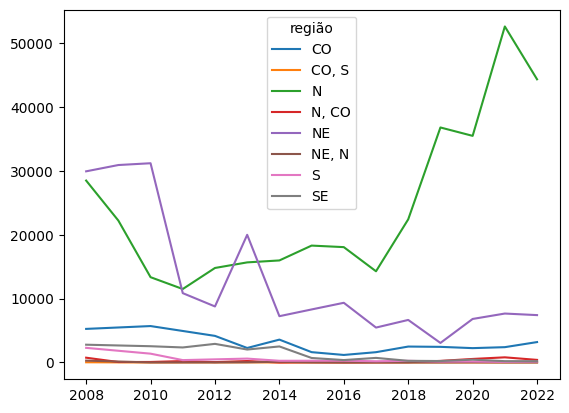

In [ ]:
colsr = cols + ['região']
gruporeg = df[colsr].groupby(by='região').aggregate('sum').T
gruporeg.plot.line()

O desmatamento de acordo com as regiões estão bastante similares à divisão feita de acordo com os biomas.

Sabemos que, pelo teste de hipótese feito anteriormente, que o desmatamento conjunto das UCs na Amazônia e no Cerrado apresentam uma diferença insignificante ao desmatamento total das UCs brasileiras. Mas certas UCs ultrapassam fronteiras entre as regiões geopolíticas brasileiras, então será que há uma diferença significativa entre o desmatamento das UCs da Amazônia e Cerrado, e o desmatamento das UCs exclusivas, ou da região Norte, ou da região Centro-Oeste? Caso não haja diferença significativa, será que há diferença significativa entre este último grupo e o desmatamento total das UCs brasileiras?  

<Axes: xlabel='região'>

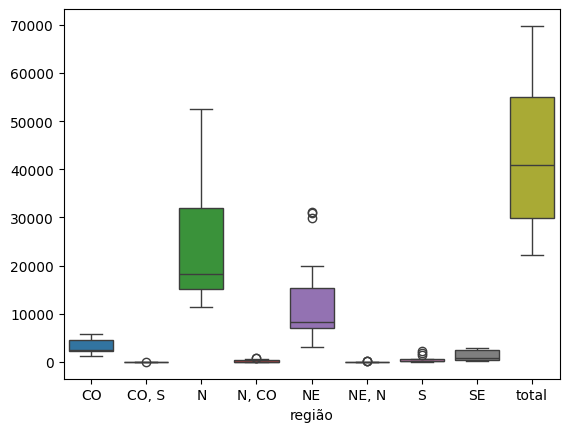

In [ ]:
sns.boxplot(data=(gruporeg.assign(total=df[cols].sum())))

In [ ]:
gruporeg

região       CO   CO, S          N   N, CO         NE    NE, N         S  \
2008    5255.31  31.330  28469.210  748.63  29914.530  289.340  2287.750   
2009    5477.26  15.665  22208.510   71.51  30900.445  146.990  1833.210   
2010    5699.21   0.000  13347.320   80.73  31180.970    4.640  1378.670   
2011    4930.86   9.250  11495.825  218.94  10850.740    7.485   371.080   
2012    4162.51  13.870  14790.240   56.06   8768.110   10.330   489.195   
2013    2268.41  18.490  15664.320  228.79  19979.280   30.610   607.310   
2014    3577.51   0.000  15968.920    0.00   7245.270  115.320   264.230   
2015    1616.75   4.245  18292.820   41.64   8299.155   15.350   271.160   
2016    1177.86   8.490  18051.910    8.73   9340.540    4.510   278.090   
2017    1611.26  10.260  14272.140   38.90   5463.210    0.000   189.710   
2018    2491.60   4.850  22401.950   47.84   6657.710    0.000   259.100   
2019    2445.82  12.090  36777.560  245.93   3057.140    1.190   143.890   
2020    2245.76   8.090  35465.560  552.14   6810.920   16.960   149.200   
2021    2396.53   0.000  52583.450  805.45   7657.610    6.940    86.580   
2022    3193.21  14.800  44315.200  405.00   7412.900    2.380   130.180   

região        SE  
2008    2781.670  
2009    2662.750  
2010    2543.830  
2011    2351.295  
2012    2911.895  
2013    2025.310  
2014    2509.530  
2015     704.365  
2016     377.810  
2017     717.430  
2018     258.290  
2019     227.850  
2020     441.370  
2021     206.270  
2022     200.880

<Axes: >

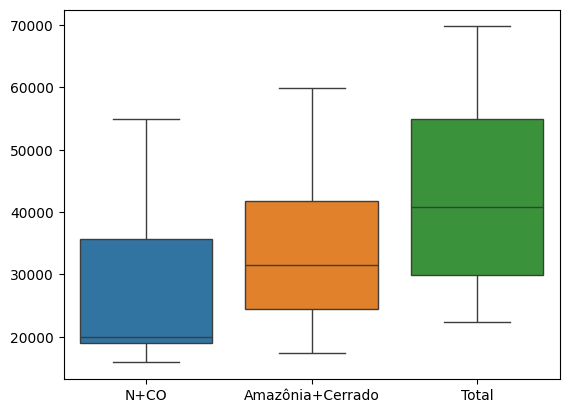

In [ ]:
nco_amc_total = pd.DataFrame({'N+CO': gruporeg['N']+gruporeg['CO'], "Amazônia+Cerrado": am, "Total": df[cols].sum()})

sns.boxplot(nco_amc_total)

In [ ]:
_, p = stats.mannwhitneyu(nco_amc_total["N+CO"], nco_amc_total['Amazônia+Cerrado'])
hip_pvalue(p, "Não há diferença significativa entre desmatamento de UCs, ou do Norte ou do Centro-Oeste, e das UCs da Amazônia e Cerrado", "Há uma diferença significativa entre os grupos")

P-value: 0.08901797772326324
Hipótese NULA não-rejeitada e (possivelmente?) aceita
[CORRETO] Não há diferença significativa entre desmatamento de UCs, ou do Norte ou do Centro-Oeste, e das UCs da Amazônia e Cerrado
Hipótese alternativa rejeitada
[INCORRETO] Há uma diferença significativa entre os grupos


Com a hipótese nula não-rejeitada, agora vamos comparar com o total:

<Axes: >

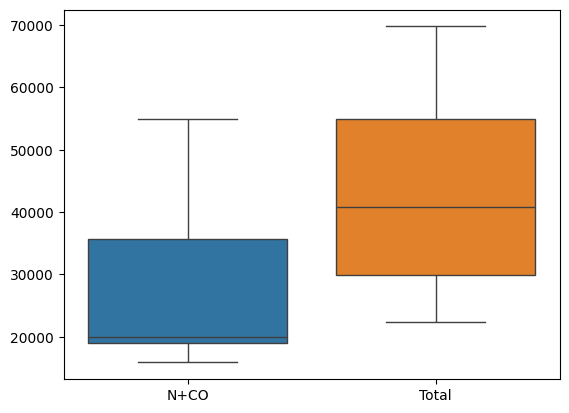

In [ ]:
sns.boxplot(nco_amc_total[['N+CO', 'Total']])

In [ ]:
_, p = stats.mannwhitneyu(nco_amc_total["N+CO"], nco_amc_total['Total'])
hip_pvalue(p, "Não há diferença significativa entre desmatamento de UCs, ou do Norte ou do Centro-Oeste, e do total de UCs do Brasil", "Há uma diferença significativa entre os grupos")

P-value: 0.004794758682161994
Hipótese nula rejeitada
[INCORRETO] Não há diferença significativa entre desmatamento de UCs, ou do Norte ou do Centro-Oeste, e do total de UCs do Brasil
Hipótese ALTERNATIVA não-rejeitada e (possivelmente?) aceita
[CORRETO] Há uma diferença significativa entre os grupos


Como podemos ver, apesar de não haver diferença significativa entre "N+CO" e
"Amazônia+Cerrado", e nem entre "Amazônia+Cerrado" e "Total"; houve sim uma diferença significativa entre "N+CO" e "Total", mostrando a importância que, certas unidades de conservação que ultrapassam fronteiras, possuem na visão geral dos índices de desmatamento.